In [3]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn.functional as F
from diffusers import UNet2DModel, AutoencoderKL
from diffusers.optimization import get_cosine_schedule_with_warmup
from dataclasses import dataclass
import matplotlib.pyplot as plt

import lpips

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

In [4]:
def topk_by_partition(input, k, axis=None, ascending=True):
    if not ascending:
        input *= -1
    ind = np.argpartition(input, k, axis=axis)
    ind = np.take(ind, np.arange(k), axis=axis) # k non-sorted indices
    input = np.take_along_axis(input, ind, axis=axis) # k non-sorted values

    # sort within k elements
    ind_part = np.argsort(input, axis=axis)
    ind = np.take_along_axis(ind, ind_part, axis=axis)
    if not ascending:
        input *= -1
    val = np.take_along_axis(input, ind_part, axis=axis) 
    return ind, val

def define_playground(length, width, num_obstacle, max_obstacle_size):
    # define playground with random obstable
    # width in axis 0, length in axis 1
    idx, _ = topk_by_partition(np.random.randn(width, length), num_obstacle)
    playground = np.zeros((width, length))
    
    for i in idx:
        ix, iy = i//length, i%length
        s = np.random.randint(max_obstacle_size)+1
        playground[ix:ix+s,iy:iy+s]=1
    #print(idx)
    #print(playground)
    return playground

def get_kernal_overlap_obstacle_area(kernal_l, kernal_w, x):
    # get obstacle area overlapped with kernal
    w, l = x.shape
    kernal_area = kernal_l * kernal_w
    #assert (l>=kernal_l) and (w>=kernal_w), 'kernal size too big'
    
    rst = np.zeros((w, l))
    for i in range(w):
        for j in range(l):
            rst[i,j]=np.sum(x[i:i+kernal_w,j:j+kernal_l])/kernal_area
    #print(rst)
    return rst

def gen_random_land(land_l, land_w, kernal_l, kernal_w):
    # generate a land with various irradiation
    #return torch.zeros((land_w, land_l)), torch.zeros((land_w, land_l))
    kernal_area = kernal_l * kernal_w
    land = np.random.random(land_l*land_w).reshape(land_w, land_l)
    land = np.where(land>0.8, land*2, land)/2
    land_panel_conv = np.zeros((land_w, land_l))
    for i in range(land_w):
        for j in range(land_l):
            land_panel_conv[i,j]=np.sum(land[i:i+kernal_w,j:j+kernal_l])/kernal_area
            
    return land, land_panel_conv
    
def prepare_input_data(cfg):
    land, land_panel_conv = gen_random_land(cfg.land_length, cfg.land_width, cfg.kernal_l, cfg.kernal_w)
    num_obstacle = np.random.randint(cfg.max_num_obstacle)+1
    land_obstacle = define_playground(cfg.land_length, cfg.land_width, num_obstacle, cfg.max_obstacle_size)
    land_obstacle_conv = get_kernal_overlap_obstacle_area(cfg.kernal_l, cfg.kernal_w, land_obstacle)
    d_in = np.stack([land_obstacle,land])
    d_out = np.stack([land_obstacle_conv,land_panel_conv])
    
    c=np.where(d_out[0:1,:,:]>0, 0, d_out[1:,:,:])
    d_max=np.zeros_like(c).reshape([c.shape[0],-1])
    d_max[np.arange(0,c.shape[0]),np.argmax(c.reshape([c.shape[0],-1]), axis=1)]=1
    d_max=d_max.reshape(c.shape)
    
    return d_in, d_out, d_max


In [5]:
@dataclass
class EnvConfig:
    render_mode = None
    seed = 42
    land_length = 36
    land_width = 36
    max_num_obstacle = 5
    max_obstacle_size = 3
    kernal_l = 3
    kernal_w = 2
    max_reward = 100 # terminate if reward > max_reward
    max_steps = 500
    
@dataclass
class TrainingConfig:
    seed = seed
    batch_size = 64
    num_of_batches = 10000
    
    gradient_accumulation_steps = 1
    learning_rate = 5e-5
    lr_warmup_steps = 200
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    #output_dir = "ddpm-butterflies-128"
    
envConfig = EnvConfig()
trainConfig = TrainingConfig()

In [6]:
#import gym
#from gym import spaces
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
from collections import OrderedDict

class PanelGridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self):
        try:
            import pygame
        except:
            pygame = None
            render_mode = None
            
        self.cfg = EnvConfig()
        self.land_length = int(self.cfg.land_length)  # The size of the square grid
        self.land_width = int(self.cfg.land_width)  # The size of the square grid
        self.max_steps = self.cfg.max_steps  # The size of the PyGame window
        self.current_step = 0

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                'panel': spaces.Box(0, 255, shape=(1, self.land_width,self.land_length), dtype=np.uint8),
                'obstruction': spaces.Box(0, 255, shape=(1, self.land_width,self.land_length), dtype=np.uint8),
                'land_irr': spaces.Box(0, 255, shape=(1, self.land_width,self.land_length), dtype=np.uint8),
            }
        ) # panel installation status, obstraction, land_irr
        self._obs_space = spaces.Box(0, 1, shape=(self.land_width,self.land_length), dtype=float)

        # Actions: move to a location, and install/uninstall a panel
        self.action_space = spaces.Discrete(self.land_width*self.land_length) #spaces.Discrete(2*self.land_width*self.land_length)

        assert self.cfg.render_mode is None or self.cfg.render_mode in self.metadata["render_modes"]
        self.render_mode = self.cfg.render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        
        self.data_raw, self.data_conv, self.data_max_irr = prepare_input_data(self.cfg)

    def _get_obs(self):
        return OrderedDict(
            [
                ('panel', (self._panel_installation_area[np.newaxis,:].copy()*255).astype(np.uint8)),
                ('obstruction', (self.data_conv[0:1].copy()*255).astype(np.uint8)),
                ('land_irr', (self.data_conv[1:].copy()*255).astype(np.uint8)),
            ]
        )

    def _get_info(self):
        return {
            "panel_installation_reward": self._reward_panel_installation,
            "obstruction_penalty": self._penalty_obstruction, # panel installed at obstruction area
            "data_raw": self.data_raw,
            "data_conv": self.data_conv,
            "data_max_irr": self.data_max_irr,
        }

    def _panel_installation_reward(self):
        # no reward for overlapping panels
        
        # define panel coverage based on kernal_l, kernal_w, ref point is left-top conner
        panel_coverage= []
        for j in range(self.cfg.kernal_w):
            panel_coverage = panel_coverage + [i+self.land_length*j for i in range(self.cfg.kernal_l)]
        panel_coverage = np.array(panel_coverage)

        # get panel placement summary, panel_placement has shape (land_width*land_length, land_width*land_length)
        # for grid with panel, value set to 1, otherwise set to 0
        # for example, land_length=4,land_width=4,kernal_l=3,kernal_w=2 and r[0]==1, then
        # panel_placement[0] = [1,1,1,0, 1,1,1,0, 0,0,0,0, 0,0,0,0]
        # for example, land_length=4,land_width=4,kernal_l=3,kernal_w=2 and r[1]==1, then
        # panel_placement[1] = [0,1,1,1, 0,1,1,1, 0,0,0,0, 0,0,0,0]
        a = []
        r = self._panel_installation.reshape(-1)
        for i in range(self.land_length*self.land_width):
            x = np.zeros(self.land_length*self.land_width)
            if r[i] and i%self.land_length<=(self.land_length-self.cfg.kernal_l) and i//self.land_length<=(self.land_width-self.cfg.kernal_w):
                x[panel_coverage+i] = 1
            a.append(x)
        panel_placement = np.stack(a)

        # find non-overlap grid, shape (land_width*land_length, land_width*land_length), 1 for non-overlap grid, 0 for overlap
        non_overlap_grid=(panel_placement.sum(axis=0)==1).astype(int)
        non_overlap_grid=np.tile(non_overlap_grid.reshape([-1,non_overlap_grid.shape[0]]),(panel_placement.shape[0],1))
        # find non_overlap panel, non-overlap panel should have non_overlap_cnt == kernal_l*kernal_w
        non_overlap_cnt=(panel_placement*non_overlap_grid)
        non_overlap_cnt=non_overlap_cnt.sum(axis=1)

        return self.data_conv[1].reshape(-1)[np.where(non_overlap_cnt==self.cfg.kernal_l*self.cfg.kernal_w)].sum()
    
    def _obstacle_penalty(self, scale=1.0):
        # logits and obstacle have shape (Batch, w, l), have values in range (0, 1)
        r = self._panel_installation.astype(float)
        loss = np.where(self.data_conv[0]>0,1,0) * r
        #print(r, logits, obstacle, loss)
        return -scale*loss.sum()

    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self.current_step = 0
        
        # default panel installation are all 0
        self._panel_installation = np.zeros([self.land_width, self.land_length]) #self._obs_space.sample()>0.9
        self._panel_installation_area = np.zeros([self.land_width, self.land_length])

        observation = self._get_obs()
        
        self._reward_panel_installation = self._panel_installation_reward() # positive
        self._penalty_obstruction = self._obstacle_penalty() # negative
        
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        # Map the action
        #self._panel_installation[action.astype(bool)] = 1 - self._panel_installation[action.astype(bool)]
        rm = action%(self.land_width*self.land_length)
        self._panel_installation[(rm//self.land_length, rm%self.land_length)] = 1 - self._panel_installation[(rm//self.land_length, rm%self.land_length)]
        if self._panel_installation[(rm//self.land_length, rm%self.land_length)]:
            self._panel_installation_area[rm//self.land_length:rm//self.land_length+self.cfg.kernal_w,
                                          rm%self.land_length:rm%self.land_length+self.cfg.kernal_l] += 1/(self.cfg.kernal_l*self.cfg.kernal_w)
        else:
            self._panel_installation_area[rm//self.land_length:rm//self.land_length+self.cfg.kernal_w,
                                          rm%self.land_length:rm%self.land_length+self.cfg.kernal_l] -= 1/(self.cfg.kernal_l*self.cfg.kernal_w)
        observation = self._get_obs()
        
        reward_panel_installation = self._panel_installation_reward() # positive
        penalty_obstruction = self._obstacle_penalty() # negative
        
        reward = reward_panel_installation + penalty_obstruction - (self._reward_panel_installation + self._penalty_obstruction)
        
        reward += -0.001 
        
        self._reward_panel_installation = reward_panel_installation
        self._penalty_obstruction = penalty_obstruction
        
        # An episode is done iff the agent has reached the target
        terminated = (self._reward_panel_installation + self._penalty_obstruction) > self.cfg.max_reward
        info = self._get_info()

        self.current_step += 1
        truncated = self.current_step >= self.max_steps
        
        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, truncated, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()


In [16]:
env = PanelGridWorldEnv()
obs, info = env.reset()
#env.data_raw, env.data_conv, env.data_max_irr
#info


In [20]:
import pickle
with open('env_36x36_data.pkl','wb') as f:
    pickle.dump((info['data_raw'],info['data_conv'],info['data_max_irr']), f)

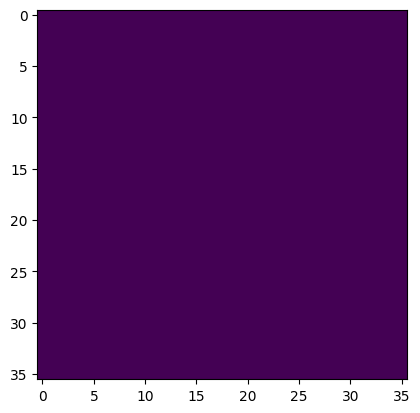

In [119]:
obs['panel'].shape
plt.imshow(obs['panel'])
#plt.imshow(env._panel_installation)

In [124]:
action = env.action_space.sample()
action
#plt.imshow(action)
#type(action[0,0])

201

In [135]:
obs, *info = env.step(action+10)
obs

OrderedDict([('panel',
              array([[0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 0, 0],
                     ...,
                     [0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)),
             ('obstruction',
              array([[0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 0, 0],
                     ...,
                     [0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 0, 0],
                     [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)),
             ('land_irr',
              array([[115,  56,  54, ...,  60,  40,  15],
                     [ 74,  41,  34, ...,  85,  65,  47],
                     [ 51,  83,  72, ..., 118,  74,  54],
                     ...,
                     [ 65,  54,  58, ...,  81,  62,  19],
                     [ 46,  

In [136]:
info

[0.16372849433497264,
 False,
 False,
 {'panel_installation_reward': 0.3961784517976169,
  'obstruction_penalty': -0.0,
  'data_raw': array([[[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]],
  
         [[0.84261659, 0.28397374, 0.33559948, ..., 0.15262286,
           0.23354933, 0.22495723],
          [0.94390135, 0.19755929, 0.11948062, ..., 0.32951962,
           0.35207051, 0.13148483],
          [0.05862392, 0.31133359, 0.11200827, ..

In [16]:
import gym
from gym import spaces
import pygame
import numpy as np
size = 3
observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,3), dtype=int),
            }
        )

observation_space.sample()

OrderedDict([('agent', array([2, 1])),
             ('target', array([[0, 2, 1],
                     [0, 2, 1]]))])

In [ ]:
import gymnasium as gym

# First, we create our environment called LunarLander-v2
env = gym.make("LunarLander-v2")

# Then we reset this environment
observation, info = env.reset()

for _ in range(20):
  # Take a random action
  action = env.action_space.sample()
  print("Action taken:", action)

  # Do this action in the environment and get
  # next_state, reward, terminated, truncated and info
  observation, reward, terminated, truncated, info = env.step(action)

  # If the game is terminated (in our case we land, crashed) or truncated (timeout)
  if terminated or truncated:
      # Reset the environment
      print("Environment is reset")
      observation, info = env.reset()

env.close()

In [12]:
@dataclass
class TrainingConfig:
    land_length = 24
    land_width = 24
    max_num_obstacle = 5
    max_obstacle_size = 3
    kernal_l = 3
    kernal_w = 2
    batch_size = 64
    num_of_batches = 10000
    
    gradient_accumulation_steps = 1
    learning_rate = 5e-5
    lr_warmup_steps = 200
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    #output_dir = "ddpm-butterflies-128"
    
config = TrainingConfig()

In [178]:
logits = torch.zeros([1,24,24])
logits[0,0]=1
panel_reward=None
th=0.8
pl=3
pw=2
loss1_weight=1.0
loss2_weight=1.0

# logits has shape (Batch, w, l), have values in range (0, 1)
B,w,l = logits.shape
logits = logits.view(B,-1) # shape (B, w*l)
if panel_reward is not None:
    panel_reward = panel_reward.view(B,-1)
else:
    panel_reward = torch.ones_like(logits)

r = torch.where(logits>th,1,0) # shape (B, w*l)

# define panel coverage based on pl, pw, ref point is left-top conner
panel_coverage= []
for j in range(pw):
    panel_coverage = panel_coverage + [i+l*j for i in range(pl)]
panel_coverage = torch.tensor(panel_coverage)

# get panel placement summary, panel_placement has shape (B, w*l, w*l)
# for grid with panel, value set to 1, otherwise set to 0
# for example, l=4,w=4,pl=3,pw=2 and r[0,0]>th, then
# panel_placement[0,0] = [1,1,1,0, 1,1,1,0, 0,0,0,0, 0,0,0,0]
# for example, l=4,w=4,pl=3,pw=2 and r[0,1]>th, then
# panel_placement[0,1] = [0,1,1,1, 0,1,1,1, 0,0,0,0, 0,0,0,0]
panel_placement = []
for j in range(B):
    a = []
    for i in range(l*w):
        x = torch.zeros_like(r[0])
        if r[j,i] and i%l<=(l-pl) and i//l<=(w-pw):
            x[panel_coverage+i] = 1
        a.append(x)
    panel_placement.append(torch.stack(a))
panel_placement = torch.stack(panel_placement)

# find non-overlap grid, shape (B, w*l, w*l), 1 for non-overlap grid, 0 for overlap
non_overlap_grid=(panel_placement.sum(dim=1)==1).to(torch.int)
non_overlap_grid=non_overlap_grid.view(non_overlap_grid.size(0),-1,non_overlap_grid.size(1)).expand(panel_placement.shape)

# find non_overlap panel, non-overlap panel should have non_overlap_cnt == pl*pw
non_overlap_cnt=(panel_placement*non_overlap_grid)
non_overlap_cnt=non_overlap_cnt.sum(dim=2)

In [179]:
non_overlap_cnt

tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

In [14]:


def panel_overlap_loss(logits, panel_reward=None, th=0.8, pl=3, pw=2, loss1_weight=1.0, loss2_weight=1.0):
    # logits has shape (Batch, w, l), have values in range (0, 1)
    B,w,l = logits.shape
    logits = logits.view(B,-1) # shape (B, w*l)
    if panel_reward is not None:
        panel_reward = panel_reward.view(B,-1)
    else:
        panel_reward = torch.ones_like(logits)
        
    r = torch.where(logits>th,1,0) # shape (B, w*l)
    
    # define panel coverage based on pl, pw, ref point is left-top conner
    panel_coverage= []
    for j in range(pw):
        panel_coverage = panel_coverage + [i+l*j for i in range(pl)]
    panel_coverage = torch.tensor(panel_coverage)
    
    # get panel placement summary, panel_placement has shape (B, w*l, w*l)
    # for grid with panel, value set to 1, otherwise set to 0
    # for example, l=4,w=4,pl=3,pw=2 and r[0,0]>th, then
    # panel_placement[0,0] = [1,1,1,0, 1,1,1,0, 0,0,0,0, 0,0,0,0]
    # for example, l=4,w=4,pl=3,pw=2 and r[0,1]>th, then
    # panel_placement[0,1] = [0,1,1,1, 0,1,1,1, 0,0,0,0, 0,0,0,0]
    panel_placement = []
    for j in range(B):
        a = []
        for i in range(l*w):
            x = torch.zeros_like(r[0])
            if r[j,i] and i%l<=(l-pl) and i//l<=(w-pw):
                x[panel_coverage+i] = 1
            a.append(x)
        panel_placement.append(torch.stack(a))
    panel_placement = torch.stack(panel_placement)
    
    # find non-overlap grid, shape (B, w*l, w*l), 1 for non-overlap grid, 0 for overlap
    non_overlap_grid=(panel_placement.sum(dim=1)==1).to(torch.int)
    non_overlap_grid=non_overlap_grid.view(non_overlap_grid.size(0),-1,non_overlap_grid.size(1)).expand(panel_placement.shape)
    
    # find non_overlap panel, non-overlap panel should have non_overlap_cnt == pl*pw
    non_overlap_cnt=(panel_placement*non_overlap_grid)
    non_overlap_cnt=non_overlap_cnt.sum(dim=2)
    
    loss1 = -1*(logits*r*panel_reward)[torch.where(non_overlap_cnt==pl*pw)].sum() # to max non-overlap panel, multiply -1 to minimize
    loss2 = (logits*r)[torch.where(non_overlap_cnt!=pl*pw)].sum() # to min overlap panel
    #print("r: ", r)
    #print("panel_placement: ", panel_placement)
    #print("non_overlap_cnt: ", non_overlap_cnt)
    #print("r*logits: ", r*logits)
    #print(loss1, loss2)
    return loss1_weight*loss1 + loss2_weight*loss2

def obstacle_loss(logits, obstacle, th=0.8):
    # logits and obstacle have shape (Batch, w, l), have values in range (0, 1)
    r = torch.where(logits>th,1,0)
    loss = torch.where(obstacle>0,1,0) * r * logits
    #print(r, logits, obstacle, loss)
    return loss.sum()

data_in, data_out, data_max = prepare_input_data(config)
#data_in[0,0]

In [15]:
data_in.shape, data_out.shape, data_max.shape

(torch.Size([64, 2, 24, 24]),
 torch.Size([64, 2, 24, 24]),
 torch.Size([64, 1, 24, 24]))

In [6]:
def transforms(examples, cfg=config):
    data_in = []
    data_out = []
    
    for i in range(len(examples['id'])):
        land, land_panel_conv = gen_random_land(cfg.land_length, cfg.land_width, cfg.kernal_l, cfg.kernal_w)
        num_obstacle = np.random.randint(cfg.max_num_obstacle)+1
        land_obstacle = define_playground(cfg.land_length, cfg.land_width, num_obstacle, cfg.max_obstacle_size)
        land_obstacle_conv = get_kernal_overlap_obstacle_area(cfg.kernal_l, cfg.kernal_w, land_obstacle)
        data_in.append(
            np.stack([land_obstacle,land])
        )
        data_out.append(
            np.stack([land_obstacle_conv,land_panel_conv])
        )
    d_out = torch.from_numpy(np.stack(data_out)).to(torch.float)
    examples['inputs'] = torch.from_numpy(np.stack(data_in)).to(torch.float)
    examples['lables'] = d_out
    
    c=torch.where(d_out[:,0:1,:,:]>0, 0, d_out[:,1:,:,:])
    d_max=torch.zeros_like(c).view(c.size(0),-1)
    d_max[torch.arange(0,c.size(0),dtype=torch.int),torch.argmax(c.view(c.size(0),-1), dim=1)]=1
    d_max=d_max.reshape(c.shape)
    examples['max_irr'] = d_max
    
    return examples

In [391]:
from datasets import Dataset
ds = Dataset.from_list([{'id':i} for i in range(100)])
ds = ds.with_transform(transforms)

In [393]:
ds[0:3]['max_irr'].shape

torch.Size([3, 1, 24, 24])

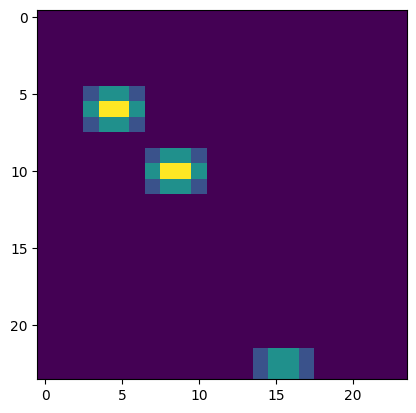

In [398]:
plt.imshow(data_out[0,0])

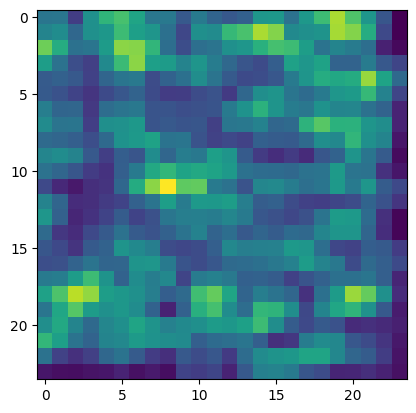

In [395]:
plt.imshow(data_out[0,1])

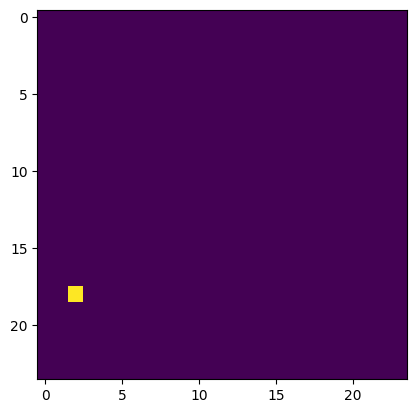

In [397]:
plt.imshow(data_max[0,0])

In [402]:
from torch import nn
#loss = F.binary_cross_entropy_with_logits(reduction='none')
din = torch.randn((2,3,3), requires_grad=True)
print(din.shape)
target = torch.empty((2,3,3)).random_(2)
print(target)
output = F.binary_cross_entropy_with_logits(din, target)
output

torch.Size([2, 3, 3])
tensor([[[0., 1., 0.],
         [0., 1., 0.],
         [1., 0., 0.]],

        [[0., 0., 1.],
         [0., 0., 1.],
         [1., 1., 0.]]])


tensor(1.0105, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [5]:
from diffusers import AutoencoderKL
model = AutoencoderKL(
    in_channels=2,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=1,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 32, 64),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownEncoderBlock2D",  # a regular ResNet downsampling block
        #"DownBlock2D", 
        "DownEncoderBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownEncoderBlock2D",
    ), 
    up_block_types=(
        "UpDecoderBlock2D",  # a regular ResNet upsampling block
        "UpDecoderBlock2D",  # a ResNet upsampling block with spatial self-attention
        #"UpBlock2D", 
        "UpDecoderBlock2D"  
    ),
    sample_size = config.batch_size,
    force_upcast = False
)

In [6]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(config.num_of_batches),
)

In [7]:
data_in, data_out, data_max = prepare_input_data(config)

In [8]:
i=8
data_in = data_in[i].expand(data_in.shape)
data_out = data_out[i].expand(data_out.shape)
data_max = data_max[i].expand(data_max.shape)

loss - 0: 10533.7958984375


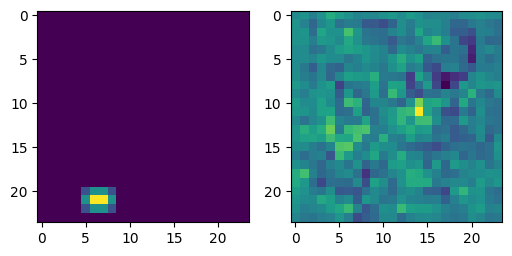

loss - 100: -1015.0147094726562


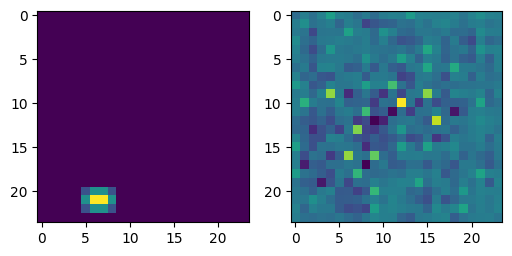

loss - 200: -70.64131164550781


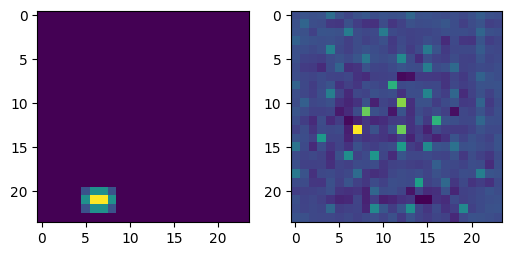

loss - 300: -1662.2587890625


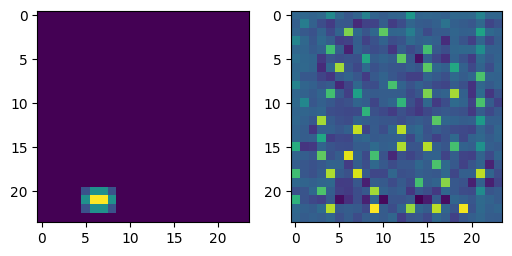

loss - 400: -2541.9833984375


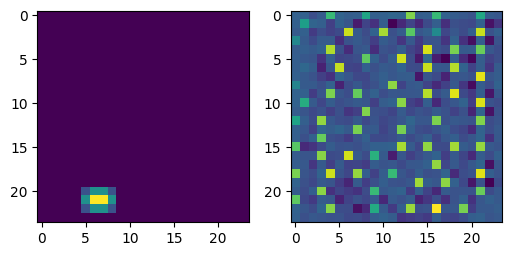

loss - 500: -3684.8916015625


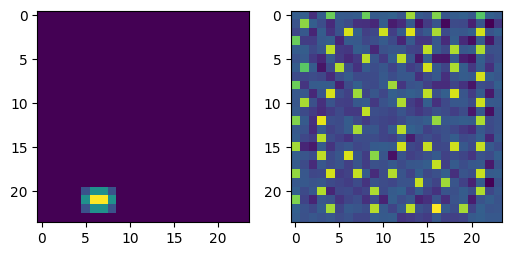

loss - 600: 1799.2984619140625


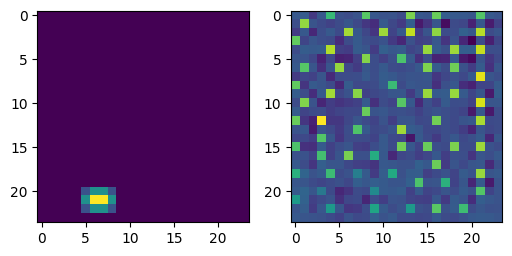

loss - 700: -4092.5078125


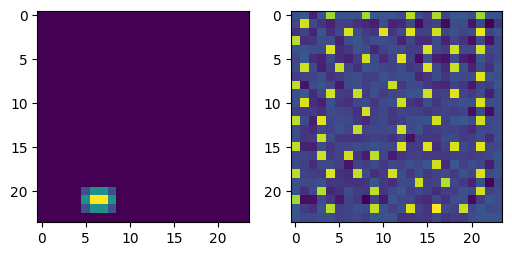

loss - 800: -4113.06396484375


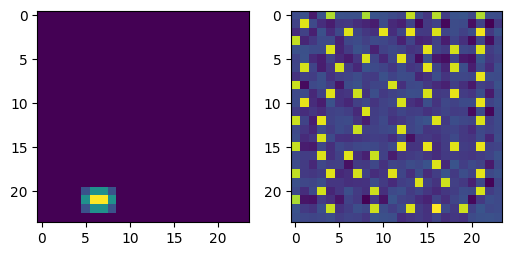

loss - 900: -3354.088134765625


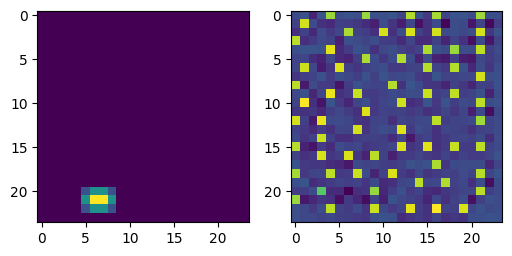

loss - 1000: -4130.7841796875


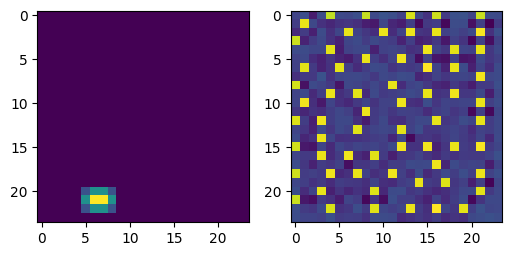

loss - 1100: -4135.30810546875


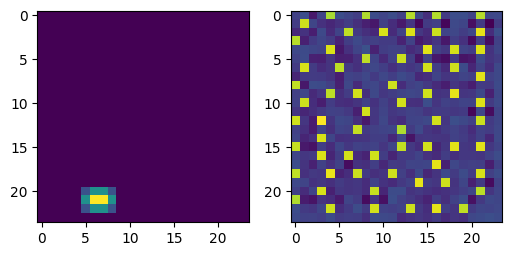

loss - 1200: -4139.90087890625


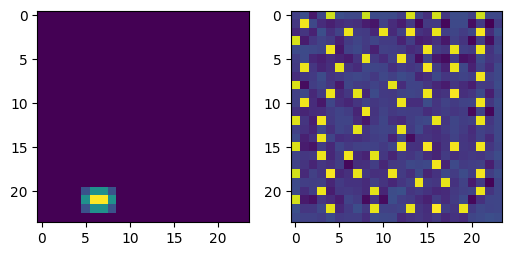

loss - 1300: -4142.8134765625


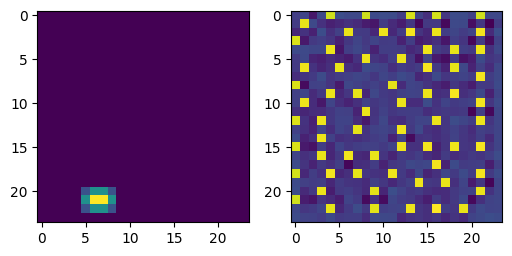

loss - 1400: -740.40771484375


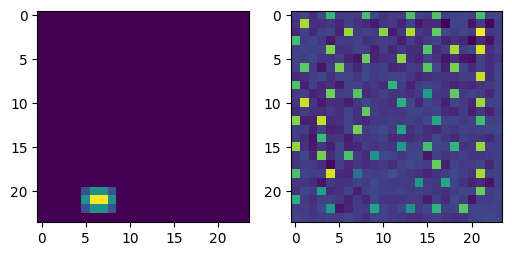

loss - 1500: -4205.25732421875


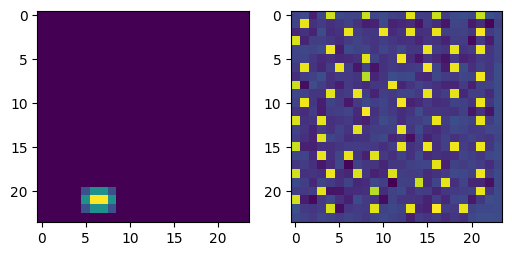

loss - 1600: -4209.654296875


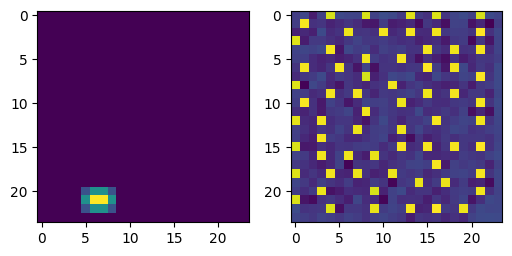

loss - 1700: -4211.9443359375


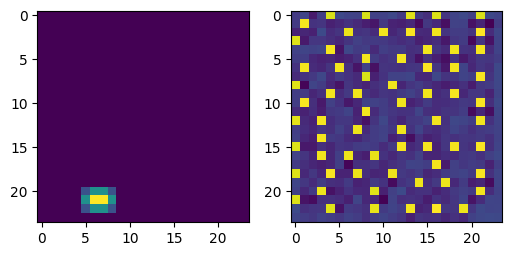

loss - 1800: -4213.5205078125


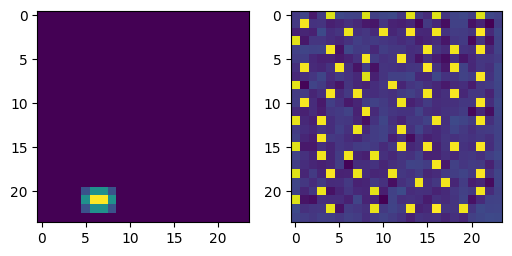

loss - 1900: -4214.6240234375


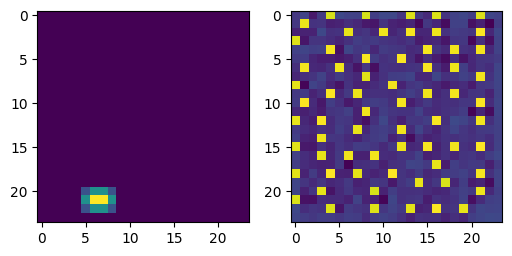

loss - 2000: -4215.66064453125


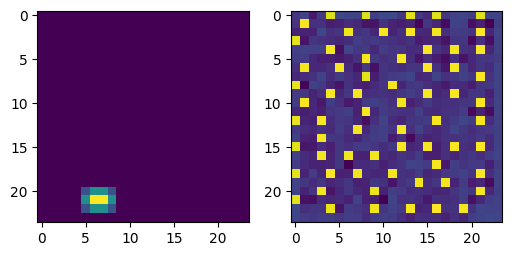

loss - 2100: -4216.47509765625


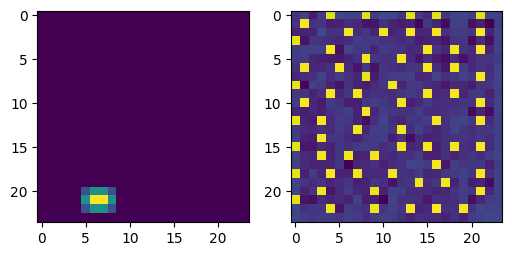

loss - 2200: -4217.14306640625


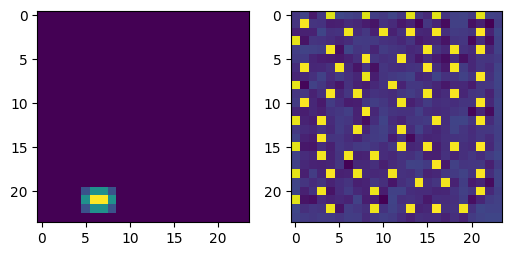

loss - 2300: -4217.73583984375


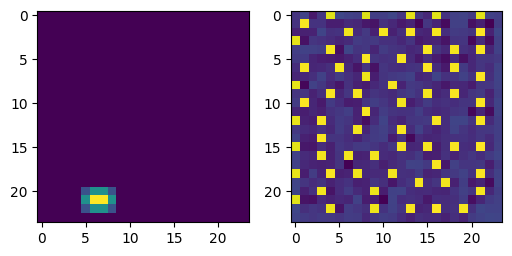

loss - 2400: -4218.24462890625


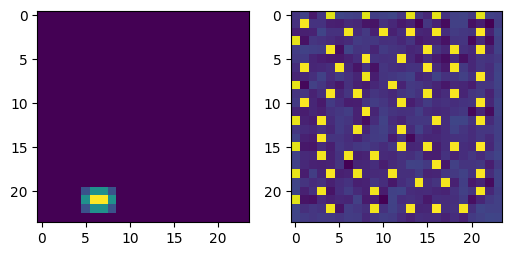

loss - 2500: -4218.69189453125


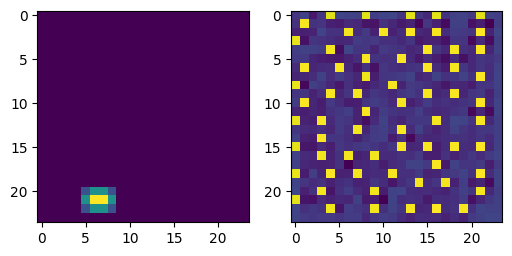

loss - 2600: -4219.0869140625


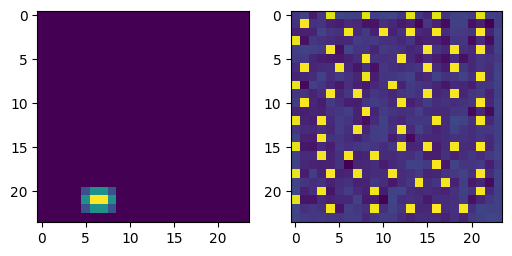

loss - 2700: -4219.439453125


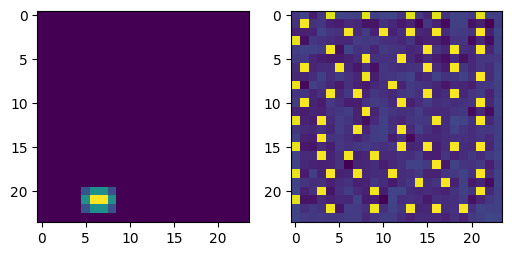

loss - 2800: -4219.75537109375


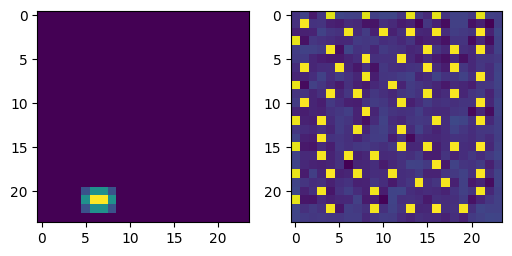

loss - 2900: -4055.051513671875


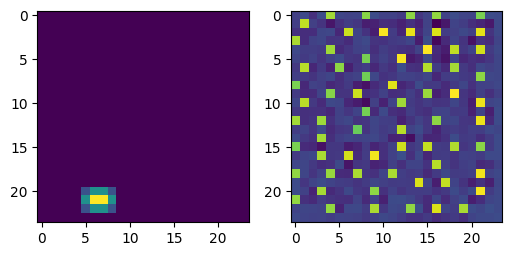

loss - 3000: -4219.13525390625


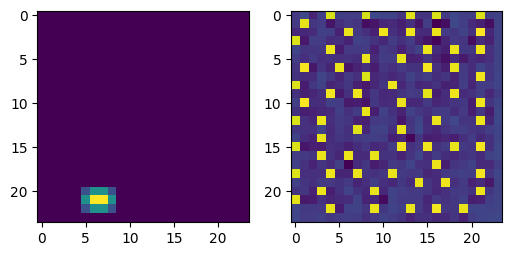

loss - 3100: -4219.9306640625


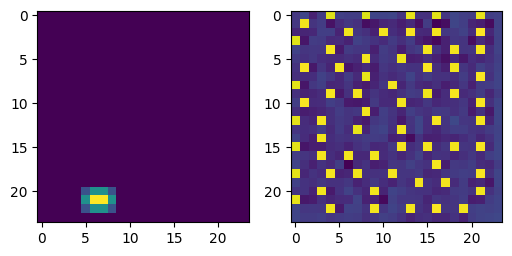

loss - 3200: -4220.3798828125


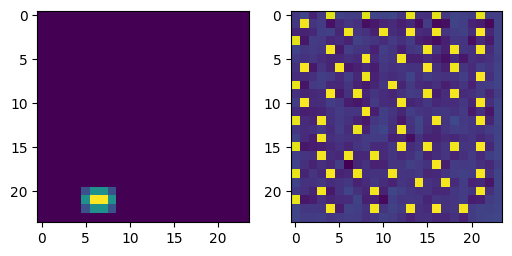

loss - 3300: -4220.6494140625


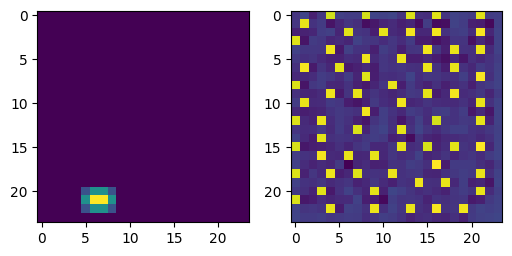

loss - 3400: -4220.94677734375


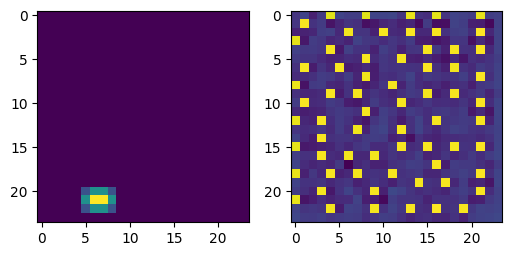

loss - 3500: -4221.16455078125


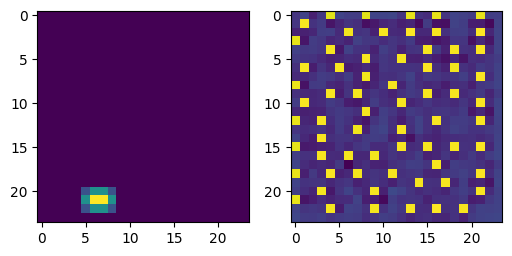

loss - 3600: -4221.31201171875


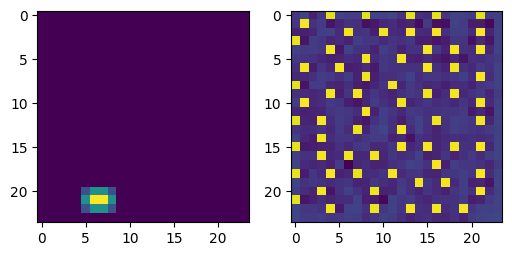

loss - 3700: -4221.501953125


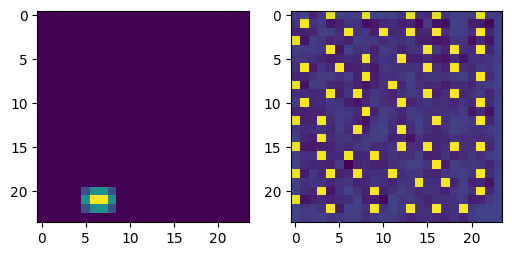

loss - 3800: -4221.65283203125


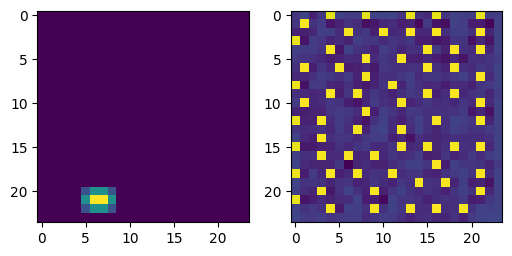

loss - 3900: -4221.78564453125


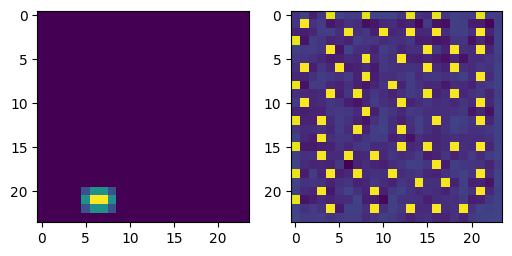

loss - 4000: -4221.90478515625


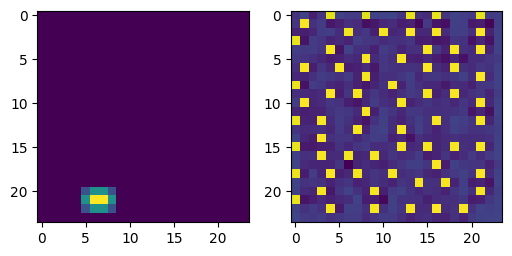

loss - 4100: -4222.01416015625


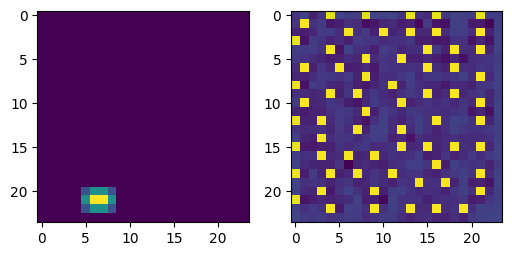

loss - 4200: -4222.11572265625


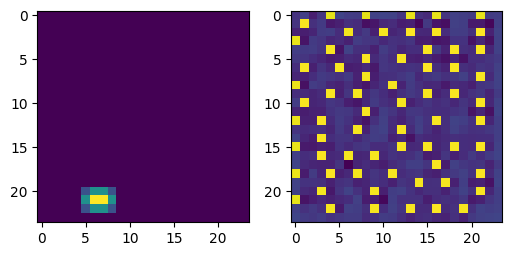

loss - 4300: -4222.20751953125


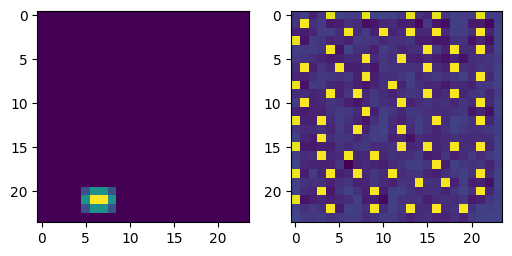

loss - 4400: -4222.2939453125


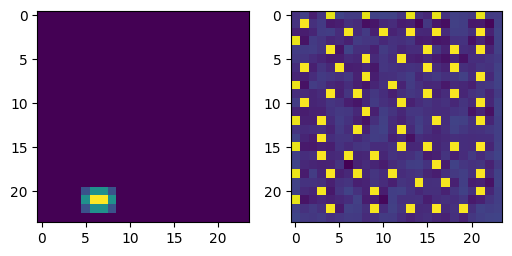

loss - 4500: -4222.37353515625


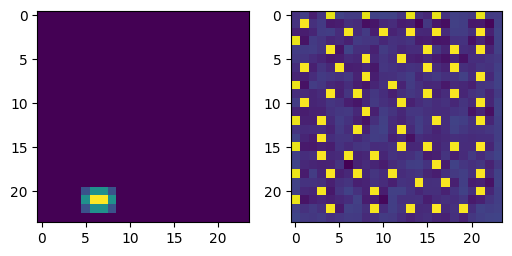

loss - 4600: -4222.447265625


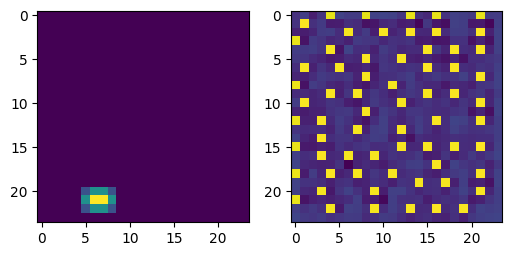

loss - 4700: -4222.5166015625


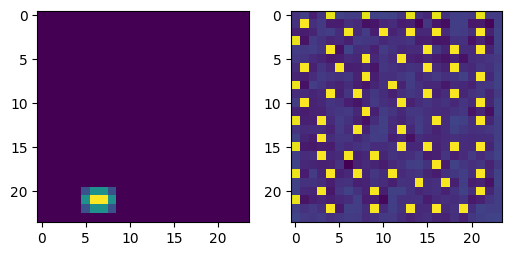

loss - 4800: -4222.5810546875


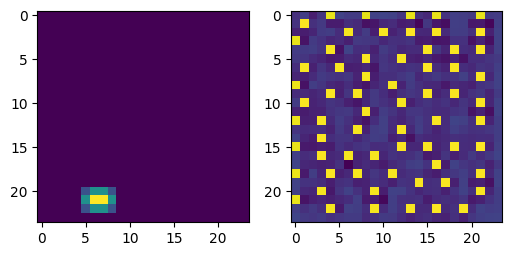

loss - 4900: -4222.64111328125


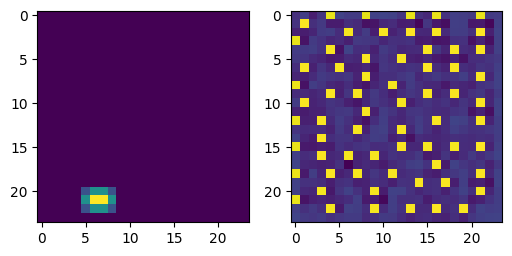

loss - 5000: -4222.69677734375


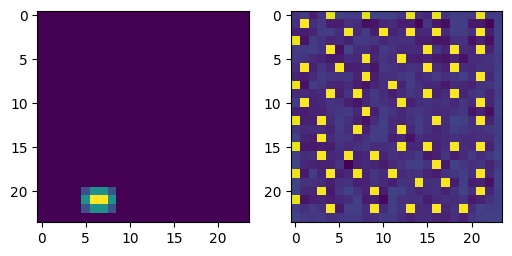

loss - 5100: -4222.75048828125


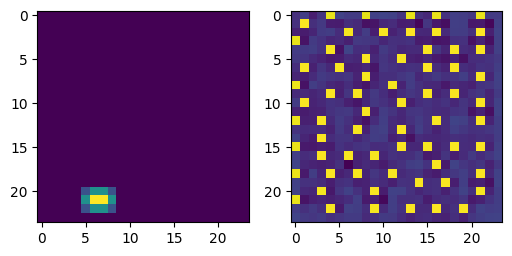

loss - 5200: -4222.7998046875


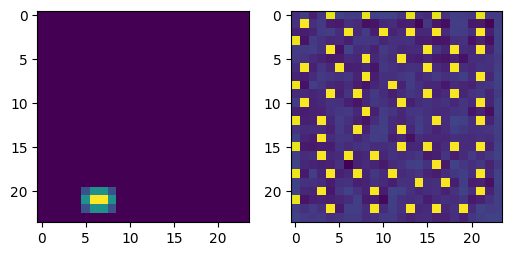

loss - 5300: -4222.84716796875


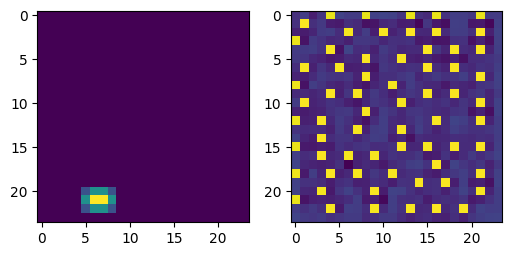

loss - 5400: -4222.89111328125


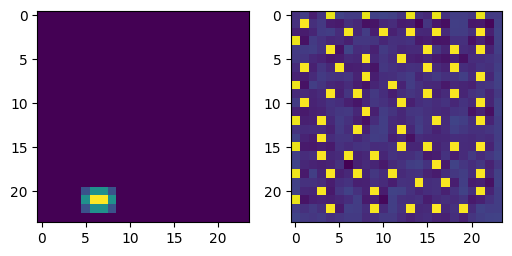

loss - 5500: -3481.734130859375


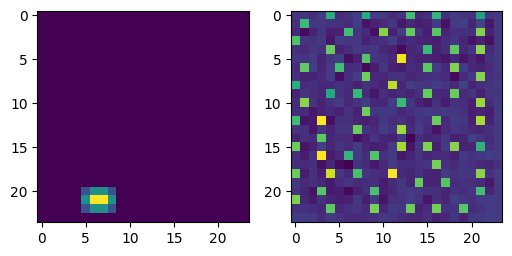

loss - 5600: -4221.587890625


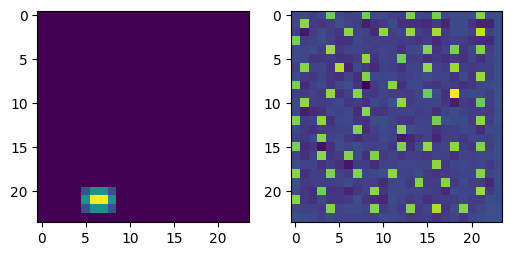

loss - 5700: -4222.25439453125


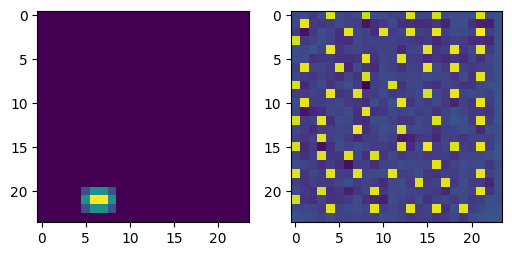

loss - 5800: -4222.5


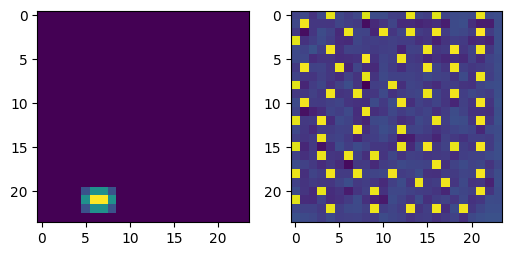

loss - 5900: -4222.64892578125


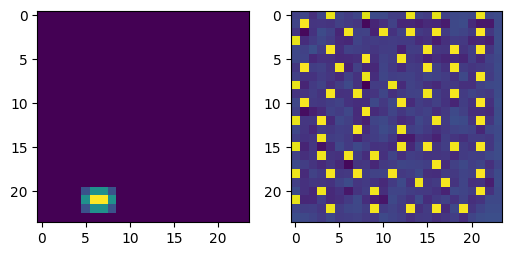

loss - 6000: -4222.75537109375


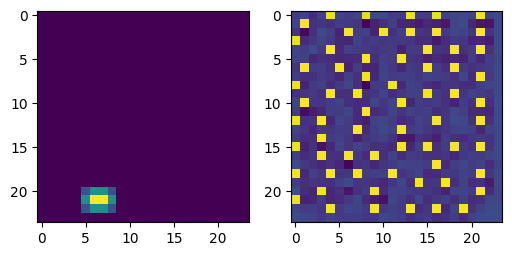

loss - 6100: -4222.837890625


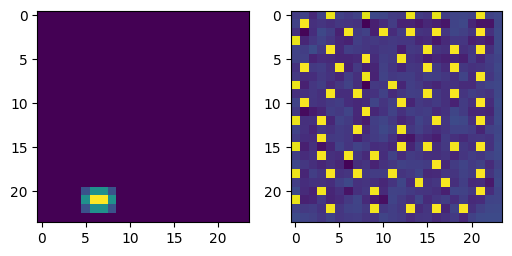

loss - 6200: -4222.9052734375


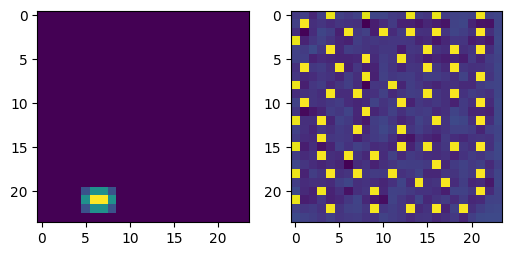

loss - 6300: -4222.9619140625


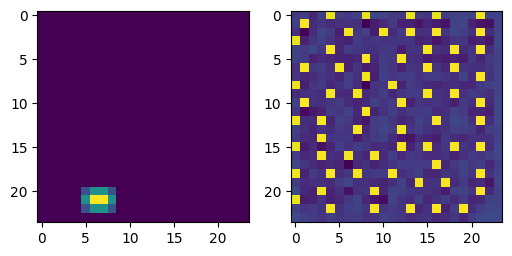

loss - 6400: -4223.01123046875


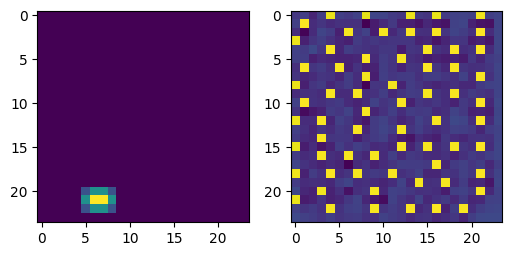

loss - 6500: -4223.05419921875


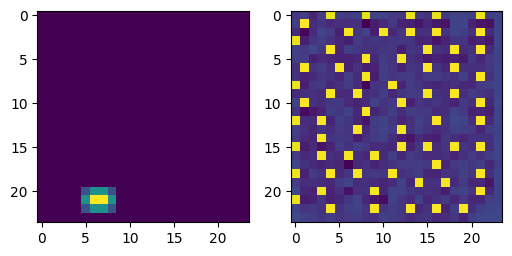

loss - 6600: -4223.09228515625


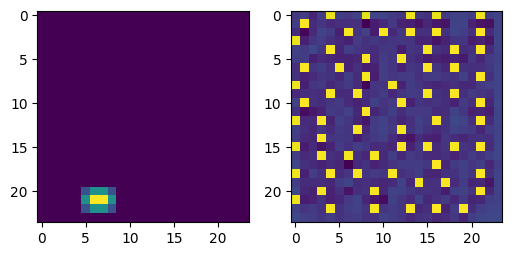

loss - 6700: -4223.12548828125


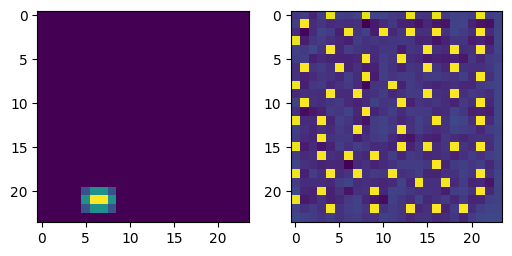

loss - 6800: -4223.15625


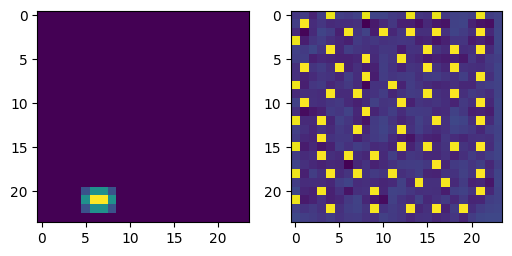

loss - 6900: -4223.18505859375


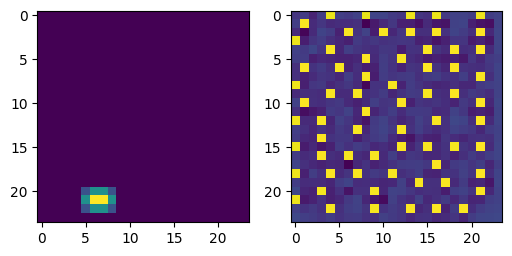

loss - 7000: -4223.2099609375


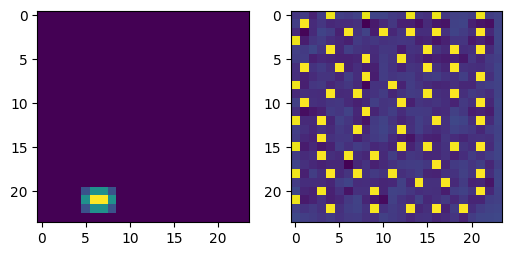

loss - 7100: -4223.23291015625


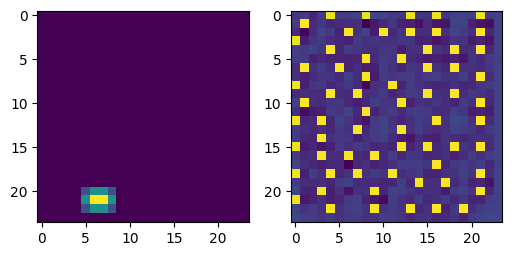

loss - 7200: -4223.2548828125


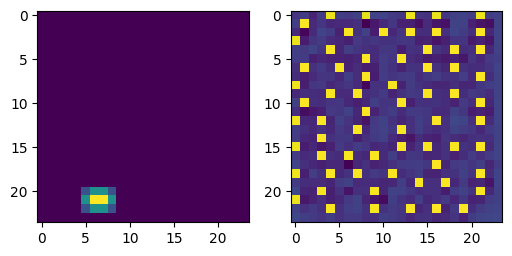

loss - 7300: -4223.2744140625


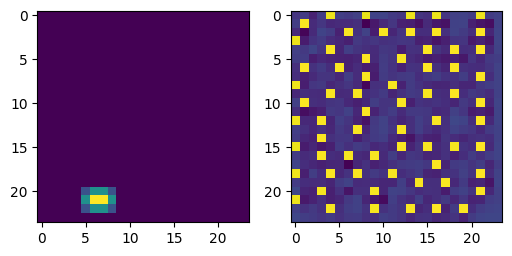

loss - 7400: -4223.29248046875


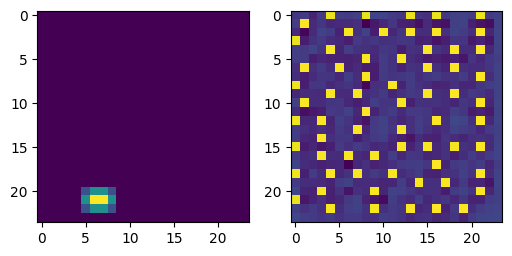

loss - 7500: -4223.30908203125


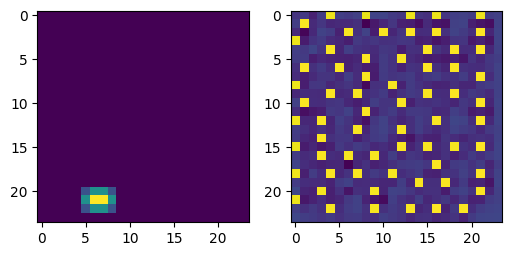

loss - 7600: -4223.32421875


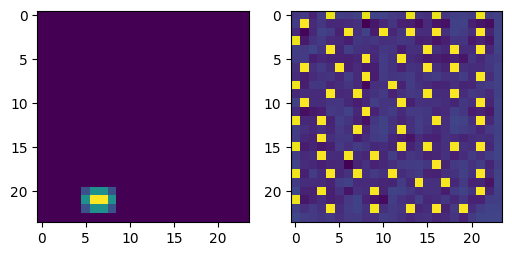

loss - 7700: -4223.3388671875


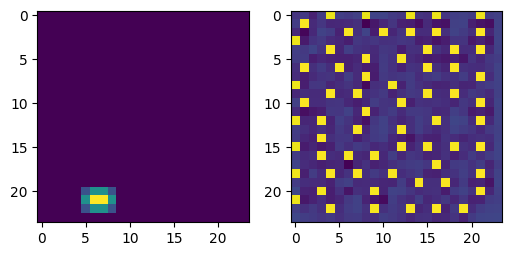

loss - 7800: -4223.35205078125


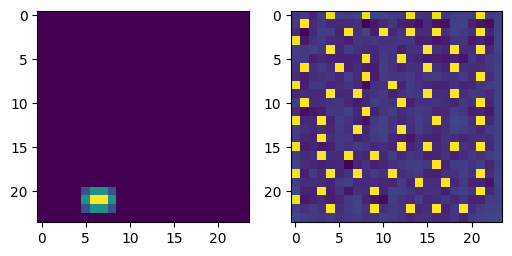

loss - 7900: -4223.36376953125


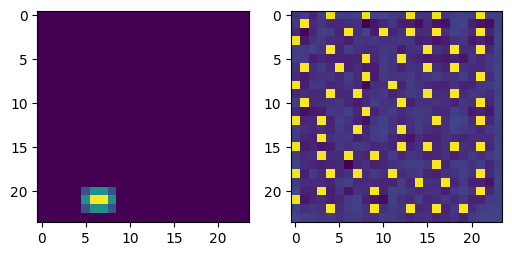

loss - 8000: -4063.39501953125


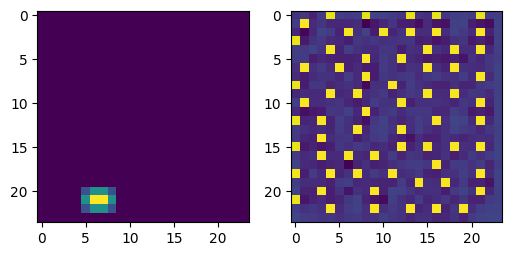

loss - 8100: -4223.376953125


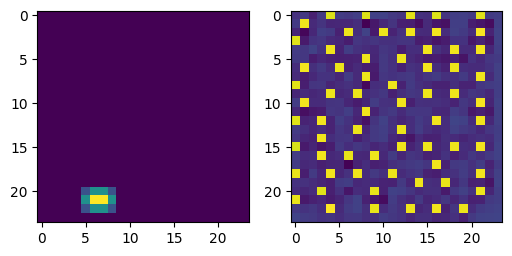

loss - 8200: -4223.3896484375


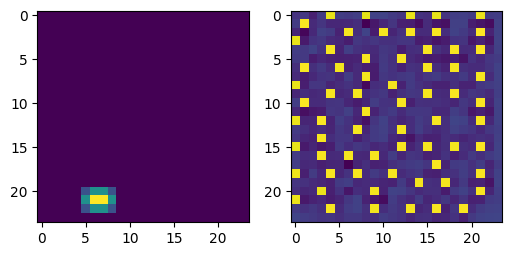

loss - 8300: -4223.39990234375


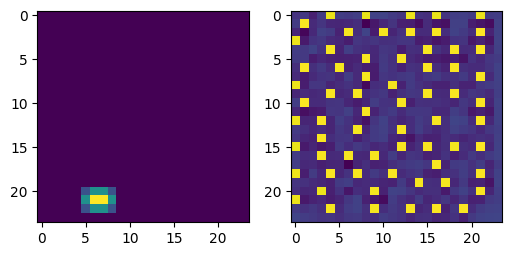

loss - 8400: -4223.40771484375


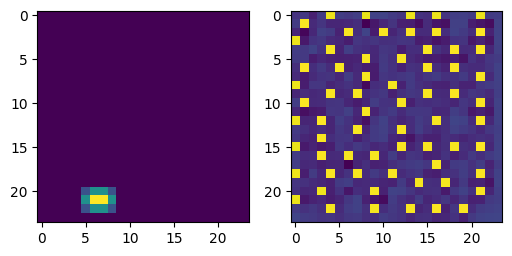

loss - 8500: -4223.4150390625


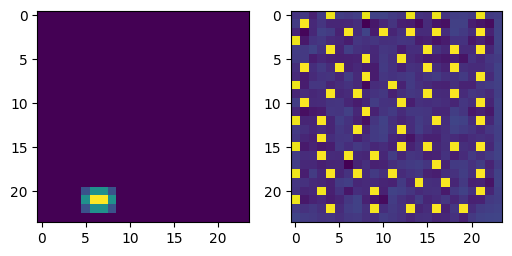

loss - 8600: -4223.421875


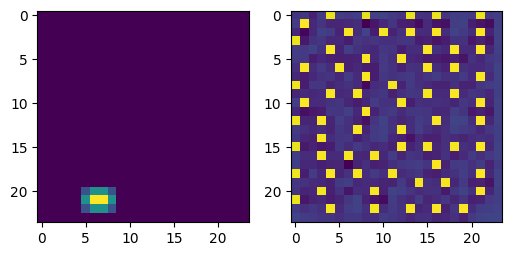

loss - 8700: -4223.42724609375


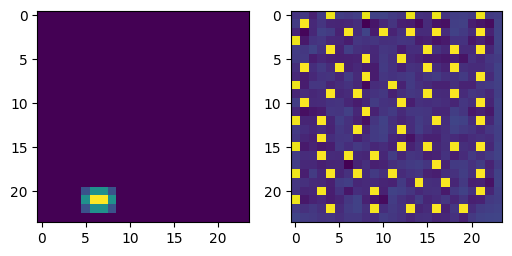

loss - 8800: -4223.4326171875


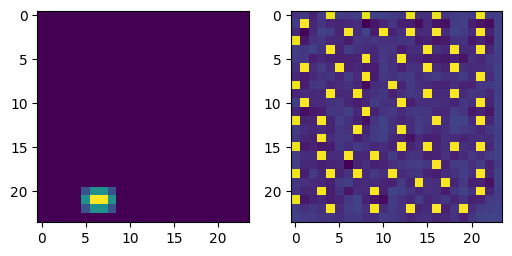

loss - 8900: -4223.43701171875


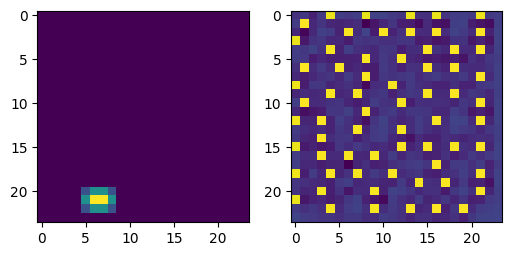

loss - 9000: -4223.43994140625


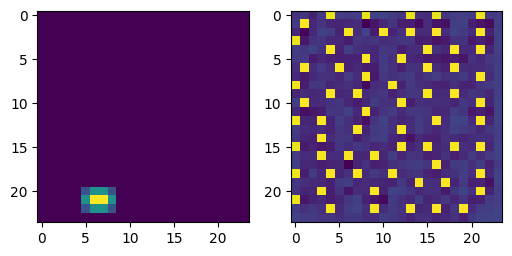

loss - 9100: -4223.443359375


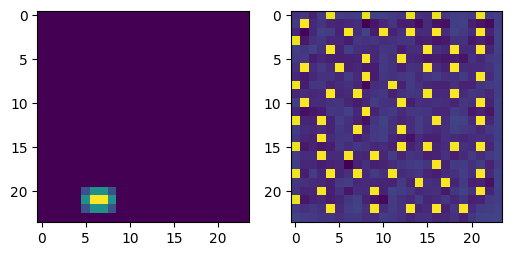

loss - 9200: -4223.44677734375


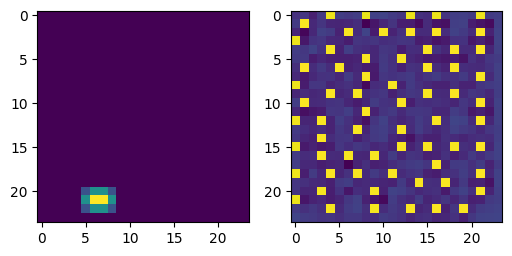

loss - 9300: -4223.44873046875


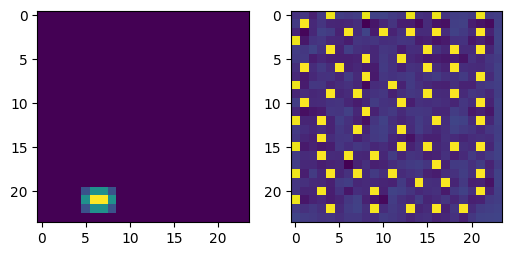

loss - 9400: -4223.44970703125


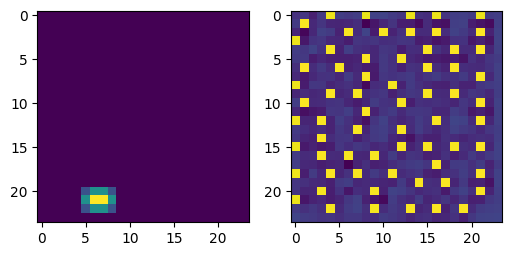

loss - 9500: -4223.45166015625


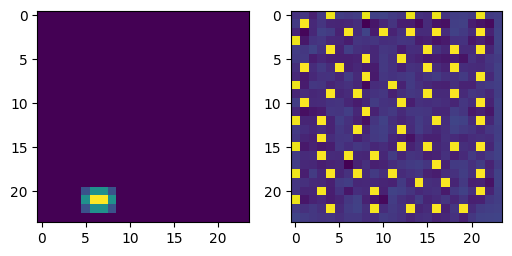

loss - 9600: -4223.4521484375


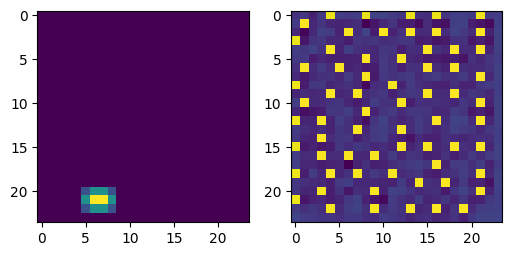

loss - 9700: -4223.453125


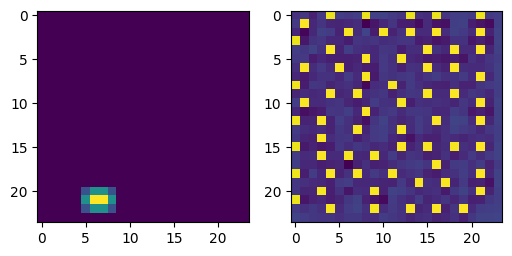

loss - 9800: -4223.453125


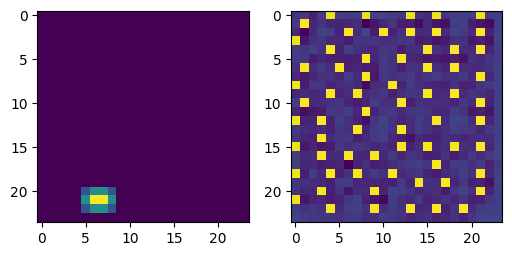

loss - 9900: -4223.453125


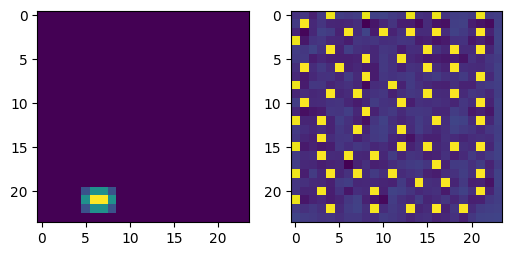

In [9]:
# Training Loop
data_in_test, data_out_test, data_max_test = prepare_input_data(config)
device = "cuda:1"
#lpips_loss_fn = lpips.LPIPS(net="alex").to(device)
model.to(device)
model.train()
loss_for_display = 0
for i in range(config.num_of_batches):
    #if loss_for_display > -4000:
    #data_in, data_out, data_max = prepare_input_data(config)
    posterior = model.encode(data_in.to(device)+torch.rand_like(data_in).to(device)*0.0).latent_dist
    z = posterior.mode()
    y = model.decode(z).sample
        
    logits = F.sigmoid(y[:,2,:,:])
    #loss1 = F.mse_loss(y[:,:2,:,:], data_out.to(device))
    loss2 = panel_overlap_loss(logits, panel_reward=None, th=0.5, pl=3, pw=2, loss1_weight=1.0, loss2_weight=1.0)
    #loss2 = F.binary_cross_entropy_with_logits(y[:,2:,:,:], data_max.to('cuda'))
    loss3 = obstacle_loss(logits, data_out[:,0,:,:].to(device), th=0.5)
    
    kl_loss = posterior.kl().mean()
    #lpips_loss = lpips_loss_fn(y[:,:2,:,:], data_out.to(device)).mean()
    
    loss = loss2 + 10*loss3 + 1*kl_loss#+ loss1 + 1*lpips_loss
    loss.backward()
    
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    
    loss_for_display = loss.item()
    
    if i%100==0:
        print(f"loss - {i}: {loss_for_display}")
        model.eval()
        posterior = model.encode(data_in.to(device)).latent_dist
        y_test = model.decode(posterior.mode()).sample
        fig, axes = plt.subplots(1, 2, figsize=(6, 15))
        axes[0].imshow(data_out[0][0])
        axes[1].imshow(y_test[0][2].cpu().detach())
        plt.show()
        
        model.train()

In [34]:
data_in[0,0,:,-3:]

tensor([[0., 0., 0.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

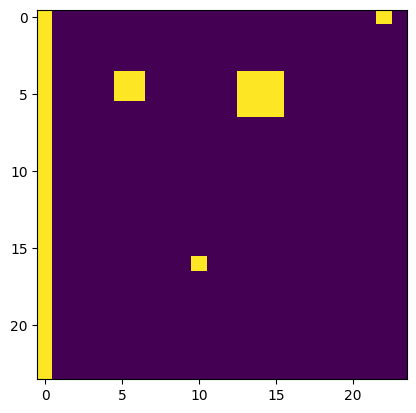

In [23]:
data_out[0,0,:,0:1] = 1
data_in[0,0,:,0:1] = 1
plt.imshow(data_in[0,0,:,:])

In [26]:
model.eval()
#data_in, data_out, data_max = prepare_input_data(config)
posterior = model.encode(data_in.to(device)).latent_dist
y = model.decode(posterior.mode()).sample

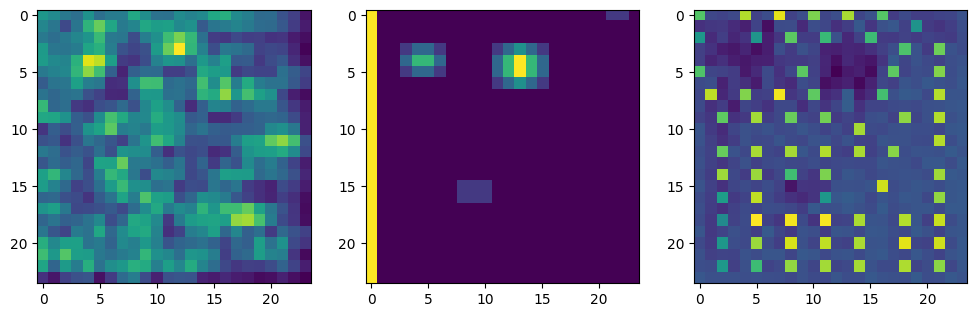

In [27]:
i=0
fig, axes = plt.subplots(1, 3, figsize=(12, 40))
axes[0].imshow(data_out[i][1])
axes[1].imshow(data_out[i][0])
axes[2].imshow(y[i][2].cpu().detach())

In [50]:
sample = x
timesteps = 0
if not torch.is_tensor(timesteps):
    timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
    timesteps = timesteps[None].to(sample.device)

In [51]:
timesteps

tensor([0])

In [60]:
import torch.nn as nn

conv_layer = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(3, 2), padding=(1,1))
conv_layer(x).shape

torch.Size([1, 5, 24, 25])

In [12]:
c = torch.ones([2,3,4,5] , dtype=torch.float)
torch.norm(c, p=2,dim=[1,2],keepdim=True).shape

torch.Size([2, 1, 1, 5])

In [9]:
(torch.tensor(2)[None] * torch.ones(5)).shape

torch.Size([5])

In [152]:
import argparse
import inspect
import logging
import math
import os
import shutil
from datetime import timedelta
from pathlib import Path

import accelerate
import datasets
import torch
import torch.nn.functional as F
from accelerate import Accelerator, InitProcessGroupKwargs
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from torchvision import transforms
from tqdm.auto import tqdm

import diffusers
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from diffusers.utils import check_min_version, is_accelerate_version, is_tensorboard_available, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

In [270]:
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    if not isinstance(arr, torch.Tensor):
        arr = torch.from_numpy(arr)
        
    arr = arr.to(timesteps.device)
    res = arr[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

In [157]:
logger = get_logger(__name__, log_level="INFO")
logger

<MultiProcessAdapter __main__ (INFO)>

In [248]:
def parse_args():
    parser = argparse.ArgumentParser(description="Simple example of a training script.")
    parser.add_argument(
        "--dataset_name",
        type=str,
        default='custom',
        help=(
            "The name of the Dataset (from the HuggingFace hub) to train on (could be your own, possibly private,"
            " dataset). It can also be a path pointing to a local copy of a dataset in your filesystem,"
            " or to a folder containing files that HF Datasets can understand."
        ),
    )
    parser.add_argument(
        "--dataset_config_name",
        type=str,
        default=None,
        help="The config of the Dataset, leave as None if there's only one config.",
    )
    parser.add_argument(
        "--model_config_name_or_path",
        type=str,
        default=None,
        help="The config of the UNet model to train, leave as None to use standard DDPM configuration.",
    )
    parser.add_argument(
        "--train_data_dir",
        type=str,
        default=None,
        help=(
            "A folder containing the training data. Folder contents must follow the structure described in"
            " https://huggingface.co/docs/datasets/image_dataset#imagefolder. In particular, a `metadata.jsonl` file"
            " must exist to provide the captions for the images. Ignored if `dataset_name` is specified."
        ),
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="ddpm-model-64",
        help="The output directory where the model predictions and checkpoints will be written.",
    )
    parser.add_argument("--overwrite_output_dir", action="store_true")
    parser.add_argument(
        "--cache_dir",
        type=str,
        default=None,
        help="The directory where the downloaded models and datasets will be stored.",
    )
    parser.add_argument(
        "--resolution",
        type=int,
        default=64,
        help=(
            "The resolution for input images, all the images in the train/validation dataset will be resized to this"
            " resolution"
        ),
    )
    parser.add_argument(
        "--center_crop",
        default=False,
        action="store_true",
        help=(
            "Whether to center crop the input images to the resolution. If not set, the images will be randomly"
            " cropped. The images will be resized to the resolution first before cropping."
        ),
    )
    parser.add_argument(
        "--random_flip",
        default=False,
        action="store_true",
        help="whether to randomly flip images horizontally",
    )
    parser.add_argument(
        "--train_batch_size", type=int, default=16, help="Batch size (per device) for the training dataloader."
    )
    parser.add_argument(
        "--eval_batch_size", type=int, default=16, help="The number of images to generate for evaluation."
    )
    parser.add_argument(
        "--dataloader_num_workers",
        type=int,
        default=0,
        help=(
            "The number of subprocesses to use for data loading. 0 means that the data will be loaded in the main"
            " process."
        ),
    )
    parser.add_argument("--num_epochs", type=int, default=100)
    parser.add_argument("--save_images_epochs", type=int, default=10, help="How often to save images during training.")
    parser.add_argument(
        "--save_model_epochs", type=int, default=10, help="How often to save the model during training."
    )
    parser.add_argument(
        "--gradient_accumulation_steps",
        type=int,
        default=1,
        help="Number of updates steps to accumulate before performing a backward/update pass.",
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=1e-4,
        help="Initial learning rate (after the potential warmup period) to use.",
    )
    parser.add_argument(
        "--lr_scheduler",
        type=str,
        default="cosine",
        help=(
            'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
            ' "constant", "constant_with_warmup"]'
        ),
    )
    parser.add_argument(
        "--lr_warmup_steps", type=int, default=500, help="Number of steps for the warmup in the lr scheduler."
    )
    parser.add_argument("--adam_beta1", type=float, default=0.95, help="The beta1 parameter for the Adam optimizer.")
    parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
    parser.add_argument(
        "--adam_weight_decay", type=float, default=1e-6, help="Weight decay magnitude for the Adam optimizer."
    )
    parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer.")
    parser.add_argument(
        "--use_ema",
        action="store_true",
        default=True,
        help="Whether to use Exponential Moving Average for the final model weights.",
    )
    parser.add_argument("--ema_inv_gamma", type=float, default=1.0, help="The inverse gamma value for the EMA decay.")
    parser.add_argument("--ema_power", type=float, default=3 / 4, help="The power value for the EMA decay.")
    parser.add_argument("--ema_max_decay", type=float, default=0.9999, help="The maximum decay magnitude for EMA.")
    parser.add_argument("--push_to_hub", action="store_true", help="Whether or not to push the model to the Hub.")
    parser.add_argument("--hub_token", type=str, default=None, help="The token to use to push to the Model Hub.")
    parser.add_argument(
        "--hub_model_id",
        type=str,
        default=None,
        help="The name of the repository to keep in sync with the local `output_dir`.",
    )
    parser.add_argument(
        "--hub_private_repo", action="store_true", help="Whether or not to create a private repository."
    )
    parser.add_argument(
        "--logger",
        type=str,
        default="tensorboard",
        choices=["tensorboard", "wandb"],
        help=(
            "Whether to use [tensorboard](https://www.tensorflow.org/tensorboard) or [wandb](https://www.wandb.ai)"
            " for experiment tracking and logging of model metrics and model checkpoints"
        ),
    )
    parser.add_argument(
        "--logging_dir",
        type=str,
        default="logs",
        help=(
            "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
            " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
        ),
    )
    parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
    parser.add_argument(
        "--mixed_precision",
        type=str,
        default="no",
        choices=["no", "fp16", "bf16"],
        help=(
            "Whether to use mixed precision. Choose"
            "between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >= 1.10."
            "and an Nvidia Ampere GPU."
        ),
    )
    parser.add_argument(
        "--prediction_type",
        type=str,
        default="sample",
        choices=["epsilon", "sample"],
        help="Whether the model should predict the 'epsilon'/noise error or directly the reconstructed image 'x0'.",
    )
    parser.add_argument("--ddpm_num_steps", type=int, default=1000)
    parser.add_argument("--ddpm_num_inference_steps", type=int, default=1000)
    parser.add_argument("--ddpm_beta_schedule", type=str, default="linear")
    parser.add_argument(
        "--checkpointing_steps",
        type=int,
        default=500,
        help=(
            "Save a checkpoint of the training state every X updates. These checkpoints are only suitable for resuming"
            " training using `--resume_from_checkpoint`."
        ),
    )
    parser.add_argument(
        "--checkpoints_total_limit",
        type=int,
        default=None,
        help=("Max number of checkpoints to store."),
    )
    parser.add_argument(
        "--resume_from_checkpoint",
        type=str,
        default=None,
        help=(
            "Whether training should be resumed from a previous checkpoint. Use a path saved by"
            ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
        ),
    )
    parser.add_argument(
        "--enable_xformers_memory_efficient_attention", action="store_true", help="Whether or not to use xformers."
    )

    args = parser.parse_args()
    env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if env_local_rank != -1 and env_local_rank != args.local_rank:
        args.local_rank = env_local_rank

    if args.dataset_name is None and args.train_data_dir is None:
        raise ValueError("You must specify either a dataset name from the hub or a train data directory.")

    return args

# to make the code run in notebook, add below two lines
import sys
sys.argv = ['']

args = parse_args()

In [249]:
args.dataset_name

'custom'

In [250]:
logging_dir = os.path.join(args.output_dir, args.logging_dir)
accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

In [251]:
kwargs = InitProcessGroupKwargs(timeout=timedelta(seconds=7200))  # a big number for high resolution or big dataset

In [252]:
accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.logger,
        project_config=accelerator_project_config,
        kwargs_handlers=[kwargs],
    )

In [253]:
if args.logger == "tensorboard":
    if not is_tensorboard_available():
        raise ImportError("Make sure to install tensorboard if you want to use it for logging during training.")
elif args.logger == "wandb":
    if not is_wandb_available():
        raise ImportError("Make sure to install wandb if you want to use it for logging during training.")
    import wandb

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 if args.logger == "tensorboard":                                                             │
│   2 │   if not is_tensorboard_available():                                                       │
│ ❱ 3 │   │   raise ImportError("Make sure to install tensorboard if you want to use it for lo     │
│   4 elif args.logger == "wandb":                                                                 │
│   5 │   if not is_wandb_available():                                                             │
│   6 │   │   raise ImportError("Make sure to install wandb if you want to use it for logging      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ImportError: Make sure to install tensorboard if you want to use it for logging during training.

In [254]:
# `accelerate` 0.16.0 will have better support for customized saving
if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
    print('here')
    # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
    def save_model_hook(models, weights, output_dir):
        if accelerator.is_main_process:
            if args.use_ema:
                ema_model.save_pretrained(os.path.join(output_dir, "unet_ema"))

            for i, model in enumerate(models):
                model.save_pretrained(os.path.join(output_dir, "unet"))

                # make sure to pop weight so that corresponding model is not saved again
                weights.pop()

    def load_model_hook(models, input_dir):
        if args.use_ema:
            load_model = EMAModel.from_pretrained(os.path.join(input_dir, "unet_ema"), UNet2DModel)
            ema_model.load_state_dict(load_model.state_dict())
            ema_model.to(accelerator.device)
            del load_model

        for i in range(len(models)):
            # pop models so that they are not loaded again
            model = models.pop()

            # load diffusers style into model
            load_model = UNet2DModel.from_pretrained(input_dir, subfolder="unet")
            model.register_to_config(**load_model.config)

            model.load_state_dict(load_model.state_dict())
            del load_model

    accelerator.register_save_state_pre_hook(save_model_hook)
    accelerator.register_load_state_pre_hook(load_model_hook)


here


In [255]:
# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)
if accelerator.is_local_main_process:
    datasets.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    datasets.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

04/18/2024 09:15:52 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no



In [256]:
# Handle the repository creation
if accelerator.is_main_process:
    if args.output_dir is not None:
        os.makedirs(args.output_dir, exist_ok=True)

    if args.push_to_hub:
        repo_id = create_repo(
            repo_id=args.hub_model_id or Path(args.output_dir).name, exist_ok=True, token=args.hub_token
        ).repo_id

In [257]:
    # Initialize the model
    if args.model_config_name_or_path is None:
        model = UNet2DModel(
            sample_size=(config.land_length, config.land_width),  # the target image resolution
            in_channels=2,  # the number of input channels, 3 for RGB images
            out_channels=2,  # the number of output channels
            layers_per_block=1,  # how many ResNet layers to use per UNet block
            block_out_channels=(32, 32, 64),  # the number of output channes for each UNet block
            down_block_types=( 
                "DownBlock2D",  # a regular ResNet downsampling block
                #"DownBlock2D", 
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                "DownBlock2D",
            ), 
            up_block_types=(
                "UpBlock2D",  # a regular ResNet upsampling block
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                #"UpBlock2D", 
                "UpBlock2D"  
              ),
        )
    else:
        config = UNet2DModel.load_config(args.model_config_name_or_path)
        model = UNet2DModel.from_config(config)

In [258]:
# Create EMA for the model.
if args.use_ema:
    ema_model = EMAModel(
        model.parameters(),
        decay=args.ema_max_decay,
        use_ema_warmup=True,
        inv_gamma=args.ema_inv_gamma,
        power=args.ema_power,
        model_cls=UNet2DModel,
        model_config=model.config,
    )

In [259]:
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
    args.mixed_precision = accelerator.mixed_precision
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16
    args.mixed_precision = accelerator.mixed_precision

In [260]:
if args.enable_xformers_memory_efficient_attention:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warning(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        model.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")

In [261]:
# Initialize the scheduler
accepts_prediction_type = "prediction_type" in set(inspect.signature(DDPMScheduler.__init__).parameters.keys())
if accepts_prediction_type:
    print('here')
    noise_scheduler = DDPMScheduler(
        num_train_timesteps=args.ddpm_num_steps,
        beta_schedule=args.ddpm_beta_schedule,
        prediction_type=args.prediction_type,
    )
else:
    noise_scheduler = DDPMScheduler(num_train_timesteps=args.ddpm_num_steps, beta_schedule=args.ddpm_beta_schedule)
    
args.prediction_type

here


'sample'

In [262]:
# Initialize the optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

In [263]:
from datasets import Dataset
dataset = Dataset.from_list([{'id':i} for i in range(16000)])
dataset = ds.with_transform(transforms)

In [264]:
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=args.train_batch_size, shuffle=True, num_workers=args.dataloader_num_workers
)

In [265]:
# Initialize the learning rate scheduler
lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
    num_training_steps=(len(train_dataloader) * args.num_epochs),
)

# Prepare everything with our `accelerator`.
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler
)

if args.use_ema:
    ema_model.to(accelerator.device)

# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
if accelerator.is_main_process:
    run = os.path.split(os.path.abspath(''))[-1].split(".")[0]
    accelerator.init_trackers(run)

In [266]:
total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
max_train_steps = args.num_epochs * num_update_steps_per_epoch

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(dataset)}")
logger.info(f"  Num Epochs = {args.num_epochs}")
logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {max_train_steps}")

global_step = 0
first_epoch = 0

04/18/2024 09:16:28 - INFO - __main__ - ***** Running training *****
04/18/2024 09:16:28 - INFO - __main__ -   Num examples = 64000
04/18/2024 09:16:28 - INFO - __main__ -   Num Epochs = 100
04/18/2024 09:16:28 - INFO - __main__ -   Instantaneous batch size per device = 16
04/18/2024 09:16:28 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 16
04/18/2024 09:16:28 - INFO - __main__ -   Gradient Accumulation steps = 1
04/18/2024 09:16:28 - INFO - __main__ -   Total optimization steps = 400000


In [271]:
# Train!
for epoch in range(first_epoch, args.num_epochs):
    model.train()
    progress_bar = tqdm(total=num_update_steps_per_epoch, disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in enumerate(train_dataloader):
        # Skip steps until we reach the resumed step
        if args.resume_from_checkpoint and epoch == first_epoch and step < resume_step:
            if step % args.gradient_accumulation_steps == 0:
                progress_bar.update(1)
            continue

        clean_images = batch["lables"].to(weight_dtype)
        # Sample noise that we'll add to the images
        noise = torch.randn(clean_images.shape, dtype=weight_dtype, device=clean_images.device)
        bsz = clean_images.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bsz,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            # Predict the noise residual
            model_output = model(noisy_images, timesteps).sample

            if args.prediction_type == "epsilon":
                loss = F.mse_loss(model_output.float(), noise.float())  # this could have different weights!
            elif args.prediction_type == "sample":
                alpha_t = _extract_into_tensor(
                    noise_scheduler.alphas_cumprod, timesteps, (clean_images.shape[0], 1, 1, 1)
                )
                snr_weights = alpha_t / (1 - alpha_t)
                # use SNR weighting from distillation paper
                loss = snr_weights * F.mse_loss(model_output.float(), clean_images.float(), reduction="none")
                loss = loss.mean()
            else:
                raise ValueError(f"Unsupported prediction type: {args.prediction_type}")

            accelerator.backward(loss)

            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            if args.use_ema:
                ema_model.step(model.parameters())
            progress_bar.update(1)
            global_step += 1

            if accelerator.is_main_process:
                if global_step % args.checkpointing_steps == 0:
                    # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                    if args.checkpoints_total_limit is not None:
                        checkpoints = os.listdir(args.output_dir)
                        checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                        checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                        # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                        if len(checkpoints) >= args.checkpoints_total_limit:
                            num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                            removing_checkpoints = checkpoints[0:num_to_remove]

                            logger.info(
                                f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                            )
                            logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                            for removing_checkpoint in removing_checkpoints:
                                removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                shutil.rmtree(removing_checkpoint)

                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        if args.use_ema:
            logs["ema_decay"] = ema_model.cur_decay_value
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)
    progress_bar.close()

    accelerator.wait_for_everyone()

    # Generate sample images for visual inspection
    if accelerator.is_main_process:
        if epoch % args.save_images_epochs == 0 or epoch == args.num_epochs - 1:
            unet = accelerator.unwrap_model(model)

            if args.use_ema:
                ema_model.store(unet.parameters())
                ema_model.copy_to(unet.parameters())

            pipeline = DDPMPipeline(
                unet=unet,
                scheduler=noise_scheduler,
            )

            generator = torch.Generator(device=pipeline.device).manual_seed(0)
            # run pipeline in inference (sample random noise and denoise)
            images = pipeline(
                generator=generator,
                batch_size=args.eval_batch_size,
                num_inference_steps=args.ddpm_num_inference_steps,
                output_type="np",
            ).images

            if args.use_ema:
                ema_model.restore(unet.parameters())

            # denormalize the images and save to tensorboard
            images_processed = (images * 255).round().astype("uint8")

            if args.logger == "tensorboard":
                if is_accelerate_version(">=", "0.17.0.dev0"):
                    tracker = accelerator.get_tracker("tensorboard", unwrap=True)
                else:
                    tracker = accelerator.get_tracker("tensorboard")
                tracker.add_images("test_samples1", images_processed[:,:1,:,:].transpose(0, 3, 1, 2), epoch)
                tracker.add_images("test_samples2", images_processed[:,1:,:,:].transpose(0, 3, 1, 2), epoch)
            elif args.logger == "wandb":
                # Upcoming `log_images` helper coming in https://github.com/huggingface/accelerate/pull/962/files
                accelerator.get_tracker("wandb").log(
                    {"test_samples": [wandb.Image(img) for img in images_processed], "epoch": epoch},
                    step=global_step,
                )

        if epoch % args.save_model_epochs == 0 or epoch == args.num_epochs - 1:
            # save the model
            unet = accelerator.unwrap_model(model)

            if args.use_ema:
                ema_model.store(unet.parameters())
                ema_model.copy_to(unet.parameters())

            pipeline = DDPMPipeline(
                unet=unet,
                scheduler=noise_scheduler,
            )

            pipeline.save_pretrained(args.output_dir)

            if args.use_ema:
                ema_model.restore(unet.parameters())

            if args.push_to_hub:
                upload_folder(
                    repo_id=repo_id,
                    folder_path=args.output_dir,
                    commit_message=f"Epoch {epoch}",
                    ignore_patterns=["step_*", "epoch_*"],
                )

accelerator.end_training()

  0%|          | 0/4000 [00:00<?, ?it/s]

04/18/2024 09:22:17 - INFO - accelerate.accelerator - Saving current state to ddpm-model-64/checkpoint-500
{'norm_eps', 'norm_num_groups', 'resnet_time_scale_shift', 'num_train_timesteps', 'center_input_sample', 'time_embedding_type', 'class_embed_type', 'act_fn', 'attn_norm_num_groups', 'flip_sin_to_cos', 'attention_head_dim', 'freq_shift', 'downsample_padding', 'upsample_type', 'mid_block_scale_factor', 'num_class_embeds', 'add_attention', 'dropout', 'downsample_type'} was not found in config. Values will be initialized to default values.
Configuration saved in ddpm-model-64/checkpoint-500/unet_ema/config.json
Model weights saved in ddpm-model-64/checkpoint-500/unet_ema/diffusion_pytorch_model.safetensors
Configuration saved in ddpm-model-64/checkpoint-500/unet/config.json
Model weights saved in ddpm-model-64/checkpoint-500/unet/diffusion_pytorch_model.safetensors
04/18/2024 09:22:17 - INFO - accelerate.checkpointing - Optimizer state saved in ddpm-model-64/checkpoint-500/optimizer.b

  0%|          | 0/1000 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:127                                                                                  │
│                                                                                                  │
│   124 │   │   │   │   │   tracker = accelerator.get_tracker("tensorboard", unwrap=True)          │
│   125 │   │   │   │   else:                                                                      │
│   126 │   │   │   │   │   tracker = accelerator.get_tracker("tensorboard")                       │
│ ❱ 127 │   │   │   │   tracker.add_images("test_samples1", images_processed[:,:1,:,:].transpose   │
│   128 │   │   │   │   tracker.add_images("test_samples2", images_processed[:,1:,:,:].transpose   │
│   129 │   │   │   elif args.logger == "wandb":                                                   │
│   130 │   │   │   │   # Upcoming `log_images` helper coming in https://github.com/huggingface/   │
│                                                                                                  │
│ /opt/tljh/user/lib/python3.9/site-packages/tensorboardX/writer.py:750 in add_images              │
│                                                                                                  │
│    747 │   │   │                                                                                 │
│    748 │   │   │   dataformats = 'N' + dataformats                                               │
│    749 │   │                                                                                     │
│ ❱  750 │   │   summary = image(tag, img_tensor, dataformats=dataformats)                         │
│    751 │   │   encoded_image_string = summary.value[0].image.encoded_image_string                │
│    752 │   │   self._get_file_writer().add_summary(                                              │
│    753 │   │   │   summary, global_step, walltime)                                               │
│                                                                                                  │
│ /opt/tljh/user/lib/python3.9/site-packages/tensorboardX/summary.py:282 in image                  │
│                                                                                                  │
│   279 │   """                                                                                    │
│   280 │   tag = _clean_tag(tag)                                                                  │
│   281 │   tensor = make_np(tensor)                                                               │
│ ❱ 282 │   tensor = convert_to_HWC(tensor, dataformats)                                           │
│   283 │   # Do not assume that user passes in values in [0, 255], use data type to detect        │
│   284 │   if tensor.dtype != np.uint8:                                                           │
│   285 │   │   tensor = (tensor * 255.0).astype(np.uint8)                                         │
│                                                                                                  │
│ /opt/tljh/user/lib/python3.9/site-packages/tensorboardX/utils.py:117 in convert_to_HWC           │
│                                                                                                  │
│   114 │   if len(input_format) == 4:                                                             │
│   115 │   │   index = [input_format.find(c) for c in 'NCHW']                                     │
│   116 │   │   tensor_NCHW = tensor.transpose(index)                                              │
│ ❱ 117 │   │   tensor_CHW = make_grid(tensor_NCHW)                                                │
│   118 │   │   return tensor_CHW.transpose(1, 2, 0)                                               │
│   119 │                                                                                          │
│   120 │   if len(input_format) == 3:                       

In [269]:
timesteps.device

device(type='cuda', index=0)

In [276]:
clean_images.shape

torch.Size([16, 2, 24, 24])

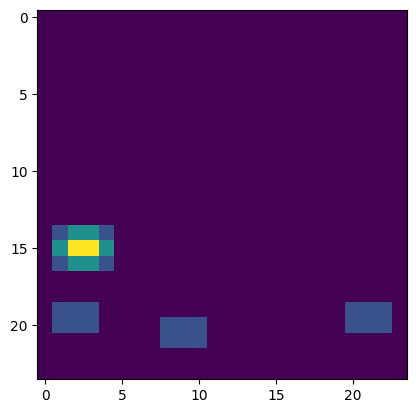

In [278]:
plt.imshow(clean_images[0,0,:,:].detach().cpu())

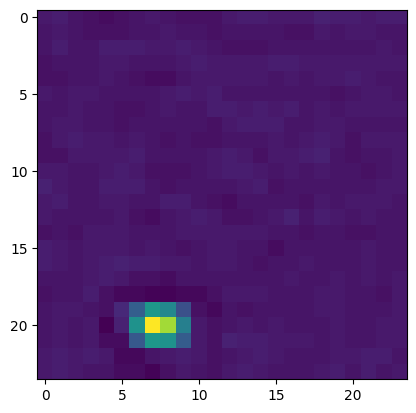

In [279]:
plt.imshow(images_processed[0,:,:,0])

In [550]:
data_in[0].view(2,-1).shape

torch.Size([2, 576])

In [567]:
def panel_overlap_loss(logits, panel_reward=None, th=0.8, pl=3, pw=2, loss1_weight=1.0, loss2_weight=1.0):
    # logits has shape (Batch, w, l), have values in range (0, 1)
    B,w,l = logits.shape
    logits = logits.view(B,-1) # shape (B, w*l)
    if panel_reward is not None:
        panel_reward = panel_reward.view(B,-1)
    else:
        panel_reward = torch.ones_like(logits)
        
    r = torch.where(logits>th,1,0) # shape (B, w*l)
    
    # define panel coverage based on pl, pw, ref point is left-top conner
    panel_coverage= []
    for j in range(pw):
        panel_coverage = panel_coverage + [i+l*j for i in range(pl)]
    panel_coverage = torch.tensor(panel_coverage)
    
    # get panel placement summary, panel_placement has shape (B, w*l, w*l)
    # for grid with panel, value set to 1, otherwise set to 0
    # for example, l=4,w=4,pl=3,pw=2 and r[0,0]>th, then
    # panel_placement[0,0] = [1,1,1,0, 1,1,1,0, 0,0,0,0, 0,0,0,0]
    # for example, l=4,w=4,pl=3,pw=2 and r[0,1]>th, then
    # panel_placement[0,1] = [0,1,1,1, 0,1,1,1, 0,0,0,0, 0,0,0,0]
    panel_placement = []
    for j in range(B):
        a = []
        for i in range(l*w):
            x = torch.zeros_like(r[0])
            if r[j,i] and i%l<=(l-pl) and i//l<=(w-pw):
                x[panel_coverage+i] = 1
            a.append(x)
        panel_placement.append(torch.stack(a))
    panel_placement = torch.stack(panel_placement)
    
    # find non-overlap grid, shape (B, w*l, w*l), 1 for non-overlap grid, 0 for overlap
    non_overlap_grid=(panel_placement.sum(dim=1)==1).to(torch.int)
    non_overlap_grid=non_overlap_grid.view(non_overlap_grid.size(0),-1,non_overlap_grid.size(1)).expand(panel_placement.shape)
    
    # find non_overlap panel, non-overlap panel should have non_overlap_cnt == pl*pw
    non_overlap_cnt=(panel_placement*non_overlap_grid)
    non_overlap_cnt=non_overlap_cnt.sum(dim=2)
    
    loss1 = -1*(logits*r*panel_reward)[torch.where(non_overlap_cnt==pl*pw)].sum() # to max non-overlap panel, multiply -1 to minimize
    loss2 = (logits*r)[torch.where(non_overlap_cnt!=pl*pw)].sum() # to min overlap panel
    #print("r: ", r)
    #print("panel_placement: ", panel_placement)
    #print("non_overlap_cnt: ", non_overlap_cnt)
    #print("r*logits: ", r*logits)
    #print(loss1, loss2)
    return loss1_weight*loss1 + loss2_weight*loss2
    
panel_overlap_loss(torch.rand((2,4,4)), th=0.8, pl=3,pw=2)

tensor(3.0299)

In [566]:
def obstacle_loss(logits, obstacle, th=0.8):
    # logits and obstacle have shape (Batch, w, l), have values in range (0, 1)
    r = torch.where(logits>th,1,0)
    loss = torch.where(obstacle>0,1,0) * r * logits
    #print(r, logits, obstacle, loss)
    return loss.sum()
    
obstacle_loss(torch.rand((2,4,4)), torch.rand((2,4,4)), th=0.8)

tensor(5.3055)

In [562]:
data_out[0,0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000

In [513]:
r = torch.where(torch.rand((2,16,))>0.8,1,0)
r

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]])

In [518]:
l = 4
w = 4
pl = 3
pw = 2
s= []
for j in range(pw):
    s = s + [i+l*j for i in range(pl)]
s = torch.tensor(s)
#s = [[i+l*j for i in range(pl)] for j in range(pw)]
a1 = []
for j in range(r.size(0)):
    a = []
    for i in range(l*w):
        x = torch.zeros_like(r[0])
        if r[j,i] and i%l<=(l-pl) and i//l<=(w-pw):
            x[s+i] = 1
        a.append(x)
    a1.append(torch.stack(a))
a1 = torch.stack(a1)
a1[1]

tensor([[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [536]:
b=(a1.sum(dim=1)==1).to(torch.int)#.repeat((1,a1.size(1),1))
b=b.view(b.size(0),-1,b.size(1)).expand(a1.shape)
b

tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,

In [503]:
b=(a.sum(dim=0)==1).to(torch.int).repeat((a.size(0),1))
b

tensor([[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]], dtype=torch.int32)

In [539]:
c=(a1*b)
d=c.sum(dim=2)
d

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0]])

In [555]:
r[torch.where(d==6)]

tensor([1, 1])

In [511]:
a[torch.where(d>=2)[0],:]

tensor([[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]])

In [495]:
a[(0,1),:]

tensor([[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]])

In [1]:
import gymnasium as gym
import gym_examples
from dataclasses import dataclass
# as an example
@dataclass
class EnvConfig:
    render_mode = None
    seed = 42
    land_length = 64
    land_width = 64
    max_num_obstacle = 5
    max_obstacle_size = 3
    kernal_l = 3
    kernal_w = 2
    max_reward = 100 # terminate if reward > max_reward
    max_steps = 500

cfg = EnvConfig()
env = gym.make('gym_examples/PanelGridWorld-v1')


/home/macul/miniconda3/lib/python3.11/site-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment gym_examples/PanelGridWorld-v1 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(


In [2]:

import gymnasium

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

In [3]:
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
#env = gym.make('gym_examples/PanelGridWorld-v1') # call this first, otherwise, make_vec_env got error
env = DummyVecEnv([lambda: Monitor(FlattenObservation(gym.make('gym_examples/PanelGridWorld-v1')))]*16)

#env = make_vec_env('gym_examples/PanelGridWorld-v1', n_envs=16)

model = PPO(
    #policy = 'MultiInputPolicy',
    policy = 'MlpPolicy',
    env = env,
    n_steps = 256,
    batch_size = 64,
    n_epochs = 4,
    gamma = 0.999,
    gae_lambda = 0.98,
    ent_coef = 0.01,
    verbose=1,
    device="cuda:0",
    learning_rate=0.0001,
    tensorboard_log="./PanelGridWorld-v1/",
    clip_range=0.2,
)

/home/macul/miniconda3/lib/python3.11/site-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment gym_examples/PanelGridWorld-v1 is out of date. You should consider upgrading to version `v2`.
  logger.deprecation(


Using cuda:0 device


In [6]:
import gymnasium as gym
env = gym.make('gym_examples/PanelGridWorld-v1') # call this first, otherwise, make_vec_env got error
#env = make_vec_env(env, n_envs=16)

In [19]:
from stable_baselines3 import HerReplayBuffer, DDPG, DQN, SAC, TD3
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.envs import BitFlippingEnv
import gymnasium as gym
env = gym.make('gym_examples/PanelGridWorld-v0') # call this first, otherwise, make_vec_env got error
env = make_vec_env('gym_examples/PanelGridWorld-v0', n_envs=16)

goal_selection_strategy = "future"

# Initialize the model
model = DQN(
    "CnnPolicy",
    env,
    #replay_buffer_class=HerReplayBuffer,
    # Parameters for HER
    #replay_buffer_kwargs=dict(
    #    n_sampled_goal=4,
    #    goal_selection_strategy=goal_selection_strategy,
    #),
    verbose=1,
)

Using cuda device


In [4]:
obs = env.reset()
obs

(OrderedDict([('panel',
               array([[[0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       ...,
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)),
              ('obstruction',
               array([[[0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       ...,
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0],
                       [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)),
              ('land_irr',
               array([[[ 62,  84,  77, ...,  60,  53,  48],
                       [ 70,  94, 129, ...,  59,  22,  13],
                       [127,  94,  96, ...,  82,  42,  21],
                       ...,
                       [ 60,  52,  72, ...,  

In [10]:
import matplotlib.pyplot as plt
plt.imshow(obs['land_irr'][0])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [4]:
model.learn(100000)

Logging to ./PanelGridWorld-v1/PPO_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -97.6    |
| time/              |          |
|    fps             | 83       |
|    iterations      | 1        |
|    time_elapsed    | 49       |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -98.3       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 2           |
|    time_elapsed         | 96          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.021614447 |
|    clip_fraction        | 0.321       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.15       |
|    explained_variance   | -0.0047

In [4]:
model.set_parameters("PPO_36by36_100Steps_EnvV1_v0")

In [4]:
for i in range(10):
    if i==0:
        model.learn(total_timesteps=4096*50, reset_num_timesteps=False)
    else:
        model.learn(total_timesteps=4096*50, reset_num_timesteps=False)
    model.save("PPO_36by36_100Steps_EnvV1_v0")

Logging to ./PanelGridWorld-v1/PPO_8
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -11.5    |
| time/              |          |
|    fps             | 87       |
|    iterations      | 1        |
|    time_elapsed    | 46       |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -10.1       |
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 2           |
|    time_elapsed         | 93          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.018846743 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.16       |
|    explained_variance   | -0.0143

KeyboardInterrupt: 

In [15]:
model.save("PPO_36by36_100Steps_v1")

In [8]:
model.set_parameters('36by36_v1')

In [31]:
model = model.load("36by36_v1", env=env)

In [11]:
model = PPO.load("36by36_v2", env=env)

In [8]:
#eval_env = Monitor(gym.make('gym_examples/PanelGridWorld-v0'))
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

mean_reward=-4.85 +/- 0.15521085666331458


In [4]:
# Enjoy trained agent
vec_env = model.get_env()
obs = vec_env.reset()


In [31]:
dir(vec_env)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_get_indices',
 '_get_target_envs',
 '_obs_from_buf',
 '_save_obs',
 'action_space',
 'actions',
 'buf_dones',
 'buf_infos',
 'buf_obs',
 'buf_rews',
 'close',
 'env_is_wrapped',
 'env_method',
 'envs',
 'get_attr',
 'get_images',
 'getattr_depth_check',
 'keys',
 'metadata',
 'num_envs',
 'observation_space',
 'render',
 'render_mode',
 'reset',
 'reset_infos',
 'seed',
 'set_attr',
 'step',
 'step_async',
 'step_wait',
 'unwrapped']

In [29]:
import numpy as np
obs, rewards, dones, info = vec_env.step(np.array([1260]*16))
rewards

array([-1.001, -1.001, -1.001, -1.001, -1.001, -1.001, -1.001, -1.001,
       -1.001, -1.001, -1.001, -1.001, -1.001, -1.001, -1.001, -1.001],
      dtype=float32)

In [30]:
vec_env.envs[0].unwrapped._reward_panel_installation, vec_env.envs[0].unwrapped._penalty_obstruction

(0.7415720333703437, -0.0)

In [12]:
vec_env.envs[0].unwrapped.data_conv[1][:,-1]

array([0.18847804, 0.05360366, 0.08239733, 0.11435705, 0.21608147,
       0.19776897, 0.09150543, 0.21548323, 0.16830528, 0.01739295,
       0.02294099, 0.08210199, 0.21116829, 0.30113842, 0.17921435,
       0.09150028, 0.07291889, 0.16787907, 0.20327864, 0.1012505 ,
       0.21841698, 0.16411806, 0.04688706, 0.0940277 , 0.10860632,
       0.07840545, 0.15749708, 0.18275686, 0.07748353, 0.097024  ,
       0.07306639, 0.065165  , 0.06865027, 0.03533808, 0.0354915 ,
       0.01027548])

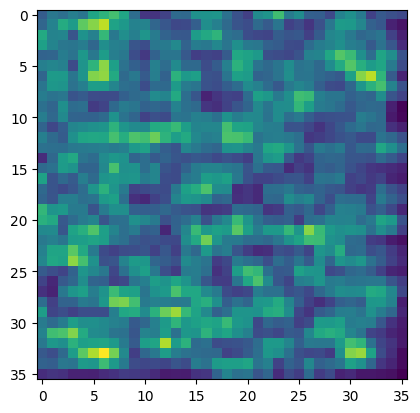

In [11]:
import matplotlib.pyplot as plt
plt.imshow(vec_env.envs[0].unwrapped.data_conv[1])

In [62]:
for i in range(1296, 1296*2):
    if obs[1,i]:
        print(i-1296)

202
203
204
205
238
239
240
241
274
275
276
277
664
665
666
667
668
700
701
702
703
704
736
737
738
739
740
772
773
774
775
776
878
879
880
914
915
916
983
984
985
986
987
1019
1020
1021
1022
1023
1055
1056
1057
1058
1059
1091
1092
1093
1094
1095


In [20]:
obs1 = obs.copy()

In [23]:
(obs == obs1).sum()

62160

In [25]:
16*3888

62208

In [21]:
action, _states = model.predict(obs, deterministic=True)
obs, rewards, dones, info = vec_env.step(action)

In [26]:
action, rewards, dones

(array([1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267, 1267,
        1267, 1267, 1267, 1267, 1267]),
 array([-0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001,
        -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001],
       dtype=float32),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]))

In [30]:
model.get_env()[0]._reward_panel_installation, model.get_env()._penalty_obstruction

TypeError: 'DummyVecEnv' object is not subscriptable

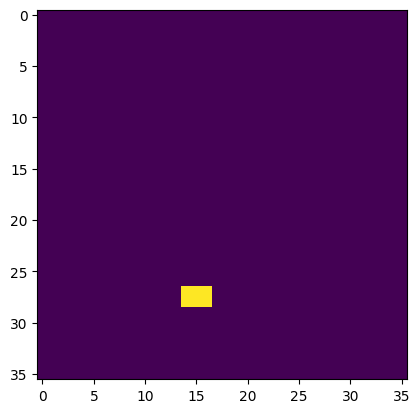

In [26]:
import matplotlib.pyplot as plt
plt.imshow(obs['panel'][0,0])

In [13]:
for i in range(10):
    action, _states = model.predict(obs, deterministic=True
                                   )
    obs, rewards, dones, info = vec_env.step(action)
    print(action, rewards)
    #vec_env.render("human")

[1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267
 1267 1267] [-0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001
 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001]
[1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267
 1267 1267] [-0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001
 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001]
[1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267
 1267 1267] [-0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001
 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001]
[1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267
 1267 1267] [-0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001
 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001]
[1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267 1267
 1267 1267] [-0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001
 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001]
[1267 1267

In [39]:
from stable_baselines3 import HerReplayBuffer, DDPG, DQN, SAC, TD3, PPO
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.envs import BitFlippingEnv

model_class = PPO  # works also with SAC, DDPG and TD3
N_BITS = 12

env = BitFlippingEnv(n_bits=N_BITS, continuous=model_class in [DDPG, SAC, TD3], max_steps=N_BITS, image_obs_space=True)

# Available strategies (cf paper): future, final, episode
goal_selection_strategy = "future" # equivalent to GoalSelectionStrategy.FUTURE

# Initialize the model
model = model_class(
    "MultiInputPolicy",
    env,
    #n_steps=64,
    #batch_size=64,
    #replay_buffer_class=HerReplayBuffer,
    # Parameters for HER
    #replay_buffer_kwargs=dict(
    #    n_sampled_goal=4,
    #    goal_selection_strategy=goal_selection_strategy,
    #),
    #gamma = 0.999,
    #gae_lambda = 0.98,
    ent_coef = 0.1,
    #learning_rate=0.001,
    verbose=1,
)

# Train the model
model.learn(100000)



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12       |
|    ep_rew_mean     | -12      |
|    success_rate    | 0.01     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | -12         |
|    success_rate         | 0           |
| time/                   |             |
|    fps                  | 383         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010685079 |
|    clip_fraction        |

In [7]:
#model.learning_rate=0.001
model.learning_rate, model.ent_coef

(0.0003, 0.01)

In [45]:
model.learn(100000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.99     |
|    ep_rew_mean     | -9.46    |
|    success_rate    | 0.53     |
| time/              |          |
|    fps             | 497      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.3         |
|    ep_rew_mean          | -8.66       |
|    success_rate         | 0.64        |
| time/                   |             |
|    fps                  | 393         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.049469717 |
|    clip_fraction        | 0.387       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76     

In [46]:
#model.save("./her_bit_env")
# Because it needs access to `env.compute_reward()`
# HER must be loaded with the env
#model = model_class.load("./her_bit_env", env=env)

obs, info = env.reset()
for _ in range(100):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    print(action, reward)
    if terminated or truncated:
        obs, info = env.reset()

9 -1.0
5 -1.0
0 -1.0
6 -1.0
2 -1.0
1 -1.0
11 -1.0
7 -1.0
3 -0.0
5 -1.0
8 -1.0
10 -1.0
2 -1.0
9 -1.0
11 -0.0
5 -1.0
9 -1.0
2 -1.0
4 -1.0
11 -1.0
1 -0.0
8 -1.0
0 -1.0
7 -1.0
3 -0.0
4 -1.0
5 -1.0
1 -1.0
2 -1.0
0 -1.0
9 -1.0
10 -1.0
8 -1.0
6 -0.0
5 -1.0
8 -1.0
3 -1.0
2 -1.0
11 -1.0
1 -0.0
8 -1.0
9 -1.0
4 -1.0
3 -1.0
0 -1.0
1 -0.0
11 -1.0
2 -1.0
6 -1.0
8 -1.0
0 -0.0
8 -1.0
7 -1.0
3 -0.0
2 -1.0
1 -1.0
8 -1.0
5 -1.0
0 -1.0
9 -1.0
7 -1.0
3 -0.0
4 -1.0
6 -1.0
0 -0.0
6 -1.0
4 -1.0
1 -1.0
7 -1.0
0 -0.0
2 -1.0
9 -1.0
1 -1.0
3 -1.0
6 -0.0
9 -1.0
2 -1.0
10 -1.0
8 -1.0
0 -1.0
3 -1.0
6 -1.0
5 -0.0
1 -1.0
9 -1.0
0 -1.0
2 -1.0
6 -1.0
10 -0.0
8 -1.0
1 -1.0
9 -1.0
11 -1.0
10 -1.0
7 -1.0
0 -0.0
9 -1.0
1 -1.0
5 -1.0
3 -1.0


In [12]:
from gymnasium import Env, spaces
a=spaces.MultiBinary(5)
a.sample()

array([1, 0, 0, 0, 0], dtype=int8)

In [16]:
a.sample()

array([0, 1, 0, 1, 0], dtype=int8)

In [15]:
import numpy as np
a=np.loadtxt('./gym_examples/gym_examples/envs/d11.csv')
b=np.loadtxt('./gym_examples/gym_examples/envs/d12.csv')

In [16]:
c=np.stack([a,b])

In [17]:
import pickle
with open('env_36x36_data.pkl', 'wb') as f:
    pickle.dump((np.zeros_like(c),c,np.zeros([1,36,36])), f)